In [1]:
#| default_exp models

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# Models
> Models currently supported by StatsForecast

StatsForecast offers a wide variety of models grouped in the following categories:

*  **Auto Forecast:** Automatic forecasting tools search for the best parameters and select the best possible model for a series of time series. These tools are useful for large collections of univariate time series. Includes automatic versions of: Arima, ETS, Theta, CES.

* **Exponential Smoothing:**  Uses a weighted average of all past observations where the weights decrease exponentially into the past. Suitable for data with clear trend and/or seasonality. Use the `SimpleExponential` family  for data with no clear trend or seasonality. Examples: SES, Holt's Winters, SSO.

* **Benchmark models:** classical models for establishing baselines. Examples: Mean, Naive, Random Walk

* **Intermittent or Sparse models:** suited for series with very few non-zero observations. Examples: CROSTON, ADIDA, IMAPA

* **Multiple Seasonalities:** suited for signals with more than one clear seasonality. Useful for low-frequency data like electricity and logs. Examples: MSTL. 

* **Theta Models:**  fit two theta lines to a deseasonalized time series, using different techniques to obtain and combine the two theta lines to produce the final forecasts. Examples: Theta, DynamicTheta

* **GARCH Model:** suited for modeling time series that exhibit non-constant volatility over time. Commonly used in finance to model stock prices, exchange rates, interest rates, and other financial instruments. The ARCH model is a particular case of GARCH. 

In [3]:
#| hide
from nbdev.showdoc import add_docs, show_doc
from fastcore.test import test_eq, test_close, test_fail

In [4]:
#| export
import warnings
from inspect import signature
from math import trunc
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
from numba import njit
from scipy.optimize import minimize

from statsforecast.arima import (
    Arima,
    auto_arima_f, forecast_arima, 
    fitted_arima, forward_arima
)
from statsforecast.ces import (
    auto_ces, forecast_ces,
    forward_ces
)
from statsforecast.ets import (
    ets_f, forecast_ets, 
    forward_ets
)
from statsforecast.mstl import mstl
from statsforecast.theta import (
    auto_theta, forecast_theta, 
    forward_theta
)
from statsforecast.garch import (
    garch_model, garch_forecast
)
from statsforecast.utils import (
    _seasonal_naive, _repeat_val_seas, 
    _naive, _repeat_val, _quantiles, 
    _calculate_sigma, _calculate_intervals,
    ConformalIntervals,
)

/Users/kevinkho/Work/statsforecast/statsforecast/core.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
#| hide
from statsforecast.utils import AirPassengers as ap

from statsforecast.garch import (
    generate_garch_data
)

In [6]:
#| hide 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import date, timedelta

def _plot_insample_pi(fcst):
    
    fig, ax = plt.subplots(1, 1, figsize = (20,7))

    sdate = date(1949,1,1) # start date 
    edate = date(1961,1,1) # end date
    dates = pd.date_range(sdate,edate-timedelta(days=1),freq='m')

    df = pd.DataFrame({'dates': dates,
                       'actual': ap,
                       'fitted': fcst['fitted'],
                       'fitted_lo_80': fcst['fitted-lo-80'], 
                       'fitted_lo_95': fcst['fitted-lo-95'], 
                       'fitted_hi_80': fcst['fitted-hi-80'],
                       'fitted_hi_95': fcst['fitted-hi-95']})
    plt.plot(df.dates, df.actual, color='firebrick', label='Actual value', linewidth=3)
    plt.plot(df.dates, df.fitted, color='navy', label='Fitted values', linewidth=3)
    plt.plot(df.dates, df.fitted_lo_80, color='darkorange', label='fitted-lo-80', linewidth=3)
    plt.plot(df.dates, df.fitted_lo_95, color='deepskyblue', label='fitted-lo-95', linewidth=3)
    plt.plot(df.dates, df.fitted_hi_80, color='darkorange', label='fitted-hi-80', linewidth=3)
    plt.plot(df.dates, df.fitted_hi_95, color='deepskyblue', label='fitted-hi-95', linewidth=3)
    plt.fill_between(df.dates, df.fitted_lo_95, df.fitted_hi_95, color = 'deepskyblue', alpha = 0.2)
    plt.fill_between(df.dates, df.fitted_lo_80, df.fitted_hi_80, color = 'darkorange', alpha = 0.3)
    plt.legend()
    
def _plot_fcst(fcst): 
    
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(ap)), ap)
    plt.plot(np.arange(len(ap), len(ap) + 13), fcst['mean'], label='mean')
    plt.plot(np.arange(len(ap), len(ap) + 13), fcst['lo-95'], color = 'r', label='lo-95')
    plt.plot(np.arange(len(ap), len(ap) + 13), fcst['hi-95'], color = 'r', label='hi-95')
    plt.plot(np.arange(len(ap), len(ap) + 13), fcst['lo-80'], color = 'g', label='lo-80')
    plt.plot(np.arange(len(ap), len(ap) + 13), fcst['hi-80'], color = 'g', label='hi-80')
    plt.legend()

In [7]:
#| exporti
def _add_fitted_pi(res, se, level):
    level = sorted(level)
    level = np.asarray(level)
    quantiles = _quantiles(level=level)
    lo = res['fitted'].reshape(-1, 1) - quantiles * se.reshape(-1, 1)
    hi = res['fitted'].reshape(-1, 1) + quantiles * se.reshape(-1, 1)
    lo = lo[:, ::-1]
    lo = {f'fitted-lo-{l}': lo[:, i] for i, l in enumerate(reversed(level))}
    hi = {f'fitted-hi-{l}': hi[:, i] for i, l in enumerate(level)}
    res = {**res, **lo, **hi}
    return res

In [8]:
#| exporti
def _add_conformal_distribution_intervals(
    fcst: Dict,
    cs: np.ndarray,
    level: List[Union[int, float]],
) -> Dict:
    """
    Adds conformal intervals to the `fcst` dict based on conformal scores `cs`.
    `level` should be already sorted. This strategy creates forecasts paths
    based on errors and calculate quantiles using those paths.
    """
    alphas = [100 - lv for lv in level]
    cuts = [alpha / 200 for alpha in reversed(alphas)]
    cuts.extend(1 - alpha / 200 for alpha in alphas)
    mean = fcst['mean'].reshape(1, -1)
    scores = np.vstack([mean - cs, mean + cs])
    quantiles = np.quantile(
        scores,
        cuts,
        axis=0,
    )
    quantiles = quantiles.reshape(len(cuts), -1)
    lo_cols = [f"lo-{lv}" for lv in reversed(level)]
    hi_cols = [f"hi-{lv}" for lv in level]
    out_cols = lo_cols + hi_cols
    for i, col in enumerate(out_cols):
        fcst[col] = quantiles[i]
    return fcst

In [9]:
#| exporti
def _get_conformal_method(method: str):
    available_methods = {
        "conformal_distribution": _add_conformal_distribution_intervals,
        #"conformal_error": _add_conformal_error_intervals,
    }
    if method not in available_methods.keys():
        raise ValueError(
            f"prediction intervals method {method} not supported "
            f'please choose one of {", ".join(available_methods.keys())}'
        )
    return available_methods[method]

In [10]:
#| exporti
class _TS:
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b
    
    def _conformity_scores(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ) -> np.ndarray:
        n_windows = self.prediction_intervals.n_windows # type: ignore[attr-defined]
        step_size = self.prediction_intervals.h # type: ignore[attr-defined]
        h = self.prediction_intervals.h # type: ignore[attr-defined]
        test_size = h + step_size * (n_windows - 1)
        steps = list(range(-test_size, -h + 1, step_size))
        cs = np.full((n_windows, h), np.nan, dtype=np.float32)
        for i_window, cutoff in enumerate(steps, start=0):
            end_cutoff = cutoff + h
            y_train = y[:, 0] if y.ndim == 2 else y
            X_train = y[:, 1:] if (y.ndim == 2 and y.shape[1] > 1) else None
            y_test = y[cutoff:] if end_cutoff == 0 else y[cutoff:end_cutoff]
            X_future = y_test[:, 1:] if (y_test.ndim == 2 and y_test.shape[1] > 1) else None
            fcst_window = self.forecast(h=h, y=y_train, X=X_train, X_future=X_future) # type: ignore[attr-defined]
            cs[i_window] = np.abs(fcst_window['mean'] - y_test)
        return cs
    
    @property
    def _conformal_method(self):
        return _get_conformal_method(self.prediction_intervals.method)

    def _store_cs(self, y, X):
        if self.prediction_intervals is not None:
            self._cs = self._conformity_scores(y, X)

    def _add_conformal_intervals(self, fcst, y, X, level):
        if self.prediction_intervals is not None and level is not None:
            cs = self._conformity_scores(y, X) if y is not None else self._cs
            res = self._conformal_method(fcst=fcst, cs=cs, level=level)
            return res
        return fcst

    def _add_predict_conformal_intervals(self, fcst, level):
        return self._add_conformal_intervals(fcst=fcst, y=None, X=None, level=level)

In [11]:
#| hide
# test conformity scores
class ZeroModel(_TS):
    
    def __init__(self, prediction_intervals: ConformalIntervals = None):
        self.prediction_intervals = prediction_intervals
    
    def __repr__(self):
        return 'SumAhead'
    
    def forecast(self, y, h, X=None, X_future=None, fitted=False, level=None):
        res = {'mean': np.zeros(h)}
        if self.prediction_intervals is not None and level is not None:
            cs = self._conformity_scores(y, X)
            res = self._conformal_method(fcst=res, cs=cs, level=level)
        return res
    
    def fit(self, y, X):
        return self
    
    def predict(self, h, X=None, level=None):
        res = {'mean': np.zeros(h)}
        return res

In [12]:
#| hide
conf_intervals = ConformalIntervals(h=12, n_windows=10)
expected_cs = np.full((conf_intervals.n_windows, conf_intervals.h), np.nan, dtype=np.float32)
cs_info = ap[-conf_intervals.h*conf_intervals.n_windows:]
for i in range(conf_intervals.n_windows):
    expected_cs[i] = cs_info[i * conf_intervals.h:(i+1) * conf_intervals.h]
current_cs = ZeroModel(conf_intervals)._conformity_scores(ap)
test_eq(expected_cs, current_cs)
zero_model = ZeroModel(conf_intervals)
fcst_conformal = zero_model.forecast(ap, h=12, level=[80, 90])
test_eq(list(fcst_conformal.keys()), ['mean', 'lo-90', 'lo-80', 'hi-80', 'hi-90'])

# <span style="color:DarkBlue"> Automatic Forecasting </span>

##  AutoARIMA

In [30]:
#| export
class AutoARIMA(_TS):
    """AutoARIMA model.

    Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) 
    model using an information criterion. Default is Akaike Information Criterion (AICc). 
    
    **Note:**<br>
    This implementation is a mirror of Hyndman's [forecast::auto.arima](https://github.com/robjhyndman/forecast).
    
    **References:**<br>
    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    
    Parameters
    ----------
    d : Optional[int] 
        Order of first-differencing.
    D : Optional[int] 
        Order of seasonal-differencing.
    max_p : int
        Max autorregresives p.
    max_q : int 
        Max moving averages q.
    max_P : int 
        Max seasonal autorregresives P.
    max_Q : int 
        Max seasonal moving averages Q.
    max_order : int 
        Max p+q+P+Q value if not stepwise selection.
    max_d : int 
        Max non-seasonal differences.
    max_D : int 
        Max seasonal differences.
    start_p : int 
        Starting value of p in stepwise procedure.
    start_q : int 
        Starting value of q in stepwise procedure.
    start_P : int 
        Starting value of P in stepwise procedure.
    start_Q : int 
        Starting value of Q in stepwise procedure.
    stationary : bool 
        If True, restricts search to stationary models.
    seasonal : bool 
        If False, restricts search to non-seasonal models.
    ic : str 
        Information criterion to be used in model selection.
    stepwise : bool
        If True, will do stepwise selection (faster).
    nmodels : int 
        Number of models considered in stepwise search.
    trace : bool 
        If True, the searched ARIMA models is reported.
    approximation : Optional[bool] 
        If True, conditional sums-of-squares estimation, final MLE.
    method : Optional[str] 
        Fitting method between maximum likelihood or sums-of-squares.
    truncate : Optional[int] 
        Observations truncated series used in model selection.
    test : str 
        Unit root test to use. See `ndiffs` for details.
    test_kwargs : Optional[str] 
        Unit root test additional arguments.
    seasonal_test : str 
        Selection method for seasonal differences.
    seasonal_test_kwargs : Optional[dict] 
        Seasonal unit root test arguments.
    allowdrift : bool (default True)
        If True, drift models terms considered.
    allowmean : bool (default True)
        If True, non-zero mean models considered.
    blambda : Optional[float] 
        Box-Cox transformation parameter.
    biasadj : bool 
        Use adjusted back-transformed mean Box-Cox.
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    alias : str 
        Custom name of the model.  
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """
    def __init__(
        self,
        d: Optional[int] = None,
        D: Optional[int] = None,
        max_p: int = 5,
        max_q: int = 5,
        max_P: int = 2,
        max_Q: int = 2,
        max_order: int = 5,
        max_d: int = 2,
        max_D: int = 1,
        start_p: int = 2,
        start_q: int = 2,
        start_P: int = 1,
        start_Q: int = 1,
        stationary: bool = False,
        seasonal: bool = True,
        ic: str = 'aicc',
        stepwise: bool = True,
        nmodels: int = 94,
        trace: bool = False,
        approximation: Optional[bool] = False,
        method: Optional[str] = None,
        truncate: Optional[bool] = None,
        test: str = 'kpss',
        test_kwargs: Optional[str] = None,
        seasonal_test: str = 'seas',
        seasonal_test_kwargs: Optional[Dict] = None,
        allowdrift: bool = False,
        allowmean: bool = False,
        blambda: Optional[float] = None,
        biasadj: bool = False,
        season_length: int = 1,
        alias: str = 'AutoARIMA',
        prediction_intervals: Optional[ConformalIntervals] = None,
    ):
        self.d=d
        self.D=D
        self.max_p=max_p
        self.max_q=max_q
        self.max_P=max_P
        self.max_Q=max_Q
        self.max_order=max_order
        self.max_d=max_d
        self.max_D=max_D
        self.start_p=start_p
        self.start_q=start_q
        self.start_P=start_P
        self.start_Q=start_Q
        self.stationary=stationary
        self.seasonal=seasonal
        self.ic=ic
        self.stepwise=stepwise
        self.nmodels=nmodels
        self.trace=trace
        self.approximation=approximation
        self.method=method
        self.truncate=truncate
        self.test=test
        self.test_kwargs=test_kwargs
        self.seasonal_test=seasonal_test
        self.seasonal_test_kwargs=seasonal_test_kwargs
        self.allowdrift=allowdrift
        self.allowmean=allowmean
        self.blambda=blambda
        self.biasadj=biasadj
        self.season_length=season_length
        self.alias = alias
        self.prediction_intervals = prediction_intervals
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the AutoARIMA model.

        Fit an AutoARIMA to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            AutoARIMA fitted model.
        """
        with np.errstate(invalid='ignore'):
            self.model_ = auto_arima_f(
                x=y,
                d=self.d,
                D=self.D,
                max_p=self.max_p,
                max_q=self.max_q,
                max_P=self.max_P,
                max_Q=self.max_Q,
                max_order=self.max_order,
                max_d=self.max_d,
                max_D=self.max_D,
                start_p=self.start_p,
                start_q=self.start_q,
                start_P=self.start_P,
                start_Q=self.start_Q,
                stationary=self.stationary,
                seasonal=self.seasonal,
                ic=self.ic,
                stepwise=self.stepwise,
                nmodels=self.nmodels,
                trace=self.trace,
                approximation=self.approximation,
                method=self.method,
                truncate=self.truncate,
                xreg=X,
                test=self.test,
                test_kwargs=self.test_kwargs,
                seasonal_test=self.seasonal_test,
                seasonal_test_kwargs=self.seasonal_test_kwargs,
                allowdrift=self.allowdrift,
                allowmean=self.allowmean,
                blambda=self.blambda,
                biasadj=self.biasadj,
                period=self.season_length
            )
            
        self._store_cs(y=y, X=X)
        return self
    
    def predict(
            self, 
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
        ):
        """Predict with fitted AutoArima.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = forecast_arima(self.model_, h=h, xreg=X, level=level)
        mean = fcst['mean']
        res = {'mean': mean}
        if level is None:
            return res
        level = sorted(level)
        if self.prediction_intervals is not None:
            res = self._add_predict_conformal_intervals(res, level)
        else:
            res = {
                'mean': mean,
                **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
            }
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted AutoArima insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = fitted_arima(self.model_)
        res = {'fitted': mean}
        if level is not None:
            se = np.sqrt(self.model_['sigma2'])
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient AutoARIMA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenpus of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x) optional exogenous. 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        with np.errstate(invalid='ignore'):
            mod = auto_arima_f(
                x=y,
                d=self.d,
                D=self.D,
                max_p=self.max_p,
                max_q=self.max_q,
                max_P=self.max_P,
                max_Q=self.max_Q,
                max_order=self.max_order,
                max_d=self.max_d,
                max_D=self.max_D,
                start_p=self.start_p,
                start_q=self.start_q,
                start_P=self.start_P,
                start_Q=self.start_Q,
                stationary=self.stationary,
                seasonal=self.seasonal,
                ic=self.ic,
                stepwise=self.stepwise,
                nmodels=self.nmodels,
                trace=self.trace,
                approximation=self.approximation,
                method=self.method,
                truncate=self.truncate,
                xreg=X,
                test=self.test,
                test_kwargs=self.test_kwargs,
                seasonal_test=self.seasonal_test,
                seasonal_test_kwargs=self.seasonal_test_kwargs,
                allowdrift=self.allowdrift,
                allowmean=self.allowmean,
                blambda=self.blambda,
                biasadj=self.biasadj,
                period=self.season_length
            )
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        res = {'mean': fcst['mean']}
        if fitted:
            res['fitted'] = fitted_arima(mod)
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res,
                    **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                    **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = np.sqrt(mod['sigma2'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted ARIMA model to a new time series.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self, 'model_'):
            raise Exception('You have to use the `fit` method first')
        with np.errstate(invalid='ignore'):
            mod = forward_arima(self.model_, y=y, xreg=X, method=self.method)
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        res = {'mean': fcst['mean']}
        if fitted:
            res['fitted'] = fitted_arima(mod)
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res,
                    **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                    **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = np.sqrt(mod['sigma2'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

In [32]:
#| hide
def test_class(cls_, x, h, skip_insample=False, level=None, test_forward=False):
    cls_ = cls_.fit(x)
    fcst_cls = cls_.predict(h=h)
    test_eq(len(fcst_cls['mean']), h)
    # test fit + predict equals forecast
    test_eq(
        cls_.forecast(y=x, h=h)['mean'],
        fcst_cls['mean']
    )
    if not skip_insample:
        test_eq(len(cls_.predict_in_sample()['fitted']), len(x))
        assert isinstance(cls_.predict_in_sample()['fitted'], np.ndarray)
        np.testing.assert_array_equal(
            cls_.forecast(y=x, h=h, fitted=True)['fitted'],
            cls_.predict_in_sample()['fitted'], 
        )
        if test_forward:
            np.testing.assert_array_equal(
                cls_.forward(y=x, h=h, fitted=True)['fitted'],
                cls_.predict_in_sample()['fitted'], 
            )
    
    def check_dict_equals(dict_1, dict_2):
        if not dict_1.keys() == dict_2.keys():
            return False
        return all(np.array_equal(dict_1[key], dict_2[key], equal_nan=True) for key in dict_1)
    
    if test_forward:
        if not check_dict_equals(cls_.predict(h=h), cls_.forward(y=x, h=h)):
            raise Exception('predict and forward methods are not equal')
    
    if level is not None:
        fcst_cls = cls_.predict(h=h, level=level)
        fcst_forecast = cls_.forecast(y=x, h=h, level=level)
        if not check_dict_equals(fcst_cls, fcst_forecast):
            raise Exception('predict and forecast methods are not equal with levels')
            
        if test_forward:
            if not check_dict_equals(cls_.predict(h=h, level=level), 
                                     cls_.forward(y=x, h=h, level=level)):
                raise Exception('predict and forward methods are not equal with levels')
        
        if not skip_insample:
            fcst_cls = cls_.predict_in_sample(level=level)
            fcst_forecast = cls_.forecast(y=x, h=h, level=level, fitted=True)
            fcst_forecast = {key: val for key, val in fcst_forecast.items() if 'fitted' in key}
            if not check_dict_equals(fcst_cls, fcst_forecast):
                raise Exception(
                    'predict and forecast methods are not equal with ' 
                    'levels for fitted values '
                )
            if test_forward:
                fcst_forward = cls_.forecast(y=x, h=h, level=level, fitted=True)
                fcst_forward = {key: val for key, val in fcst_forward.items() if 'fitted' in key}
                if not check_dict_equals(fcst_cls, fcst_forward):
                    raise Exception(
                        'predict and forward methods are not equal with ' 
                        'levels for fitted values '
                    )

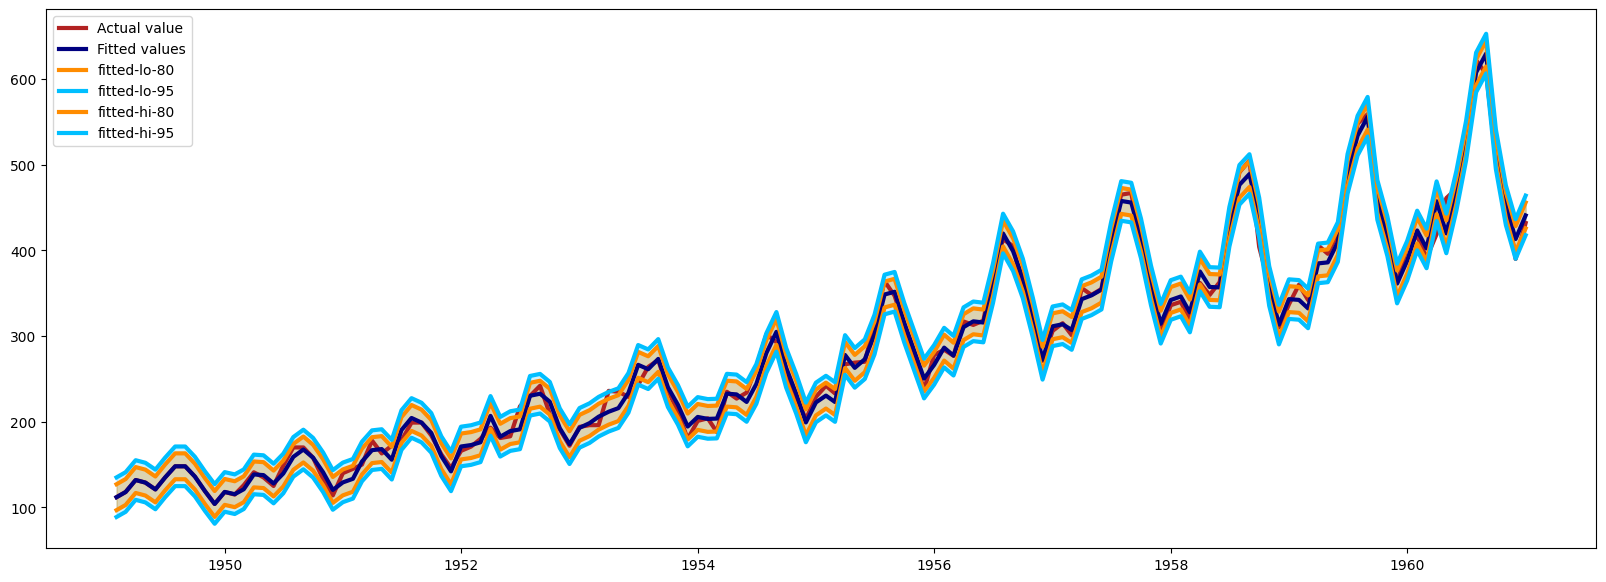

In [33]:
#| hide
arima = AutoARIMA(season_length=12) 
test_class(arima, x=ap, h=12, level=[90, 80], test_forward=True)
fcst_arima = arima.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_arima)

In [34]:
#| hide
# test conformal prediction
arima_c = AutoARIMA(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=2)) 
test_class(arima_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_arima_c = arima_c.forecast(ap, 13, None, None, (80,95), True)
test_eq(
    fcst_arima_c["mean"],
    fcst_arima["mean"],
)

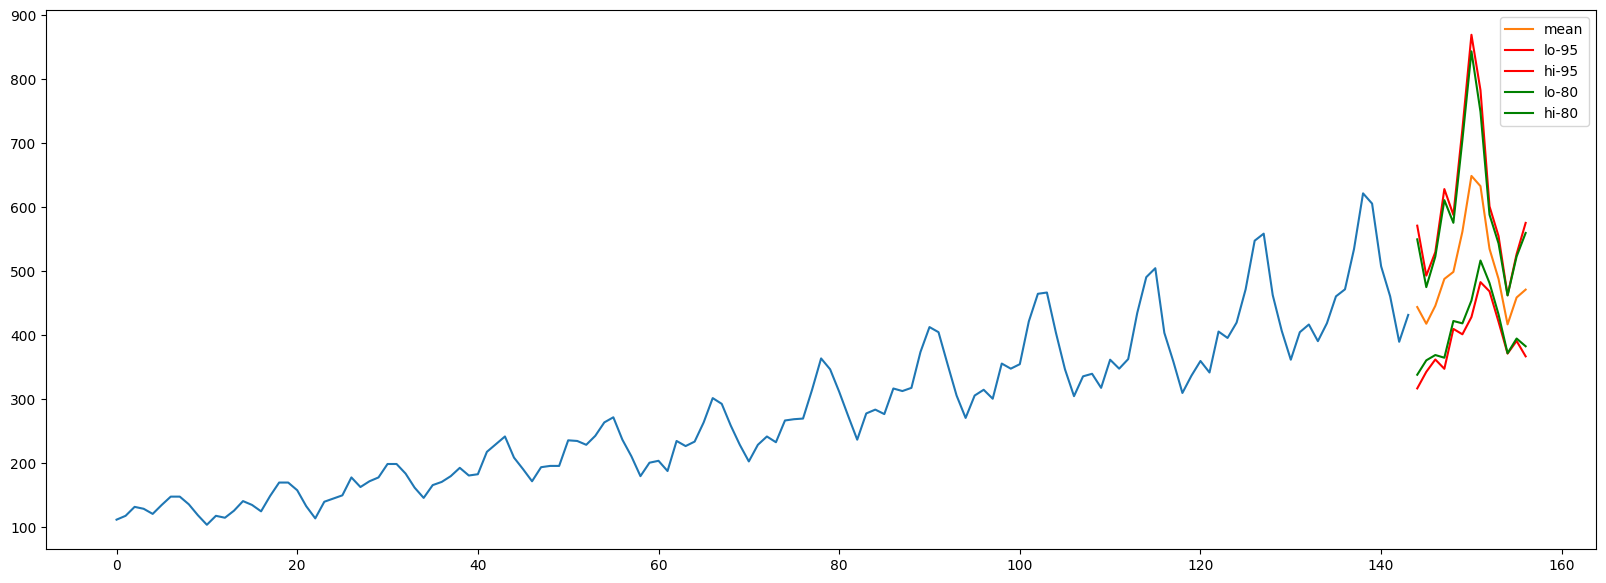

In [35]:
#| hide
_plot_fcst(fcst_arima_c)

In [36]:
#| hide
#test alias argument
test_eq(
    repr(AutoARIMA()),
    'AutoARIMA'
)
test_eq(
    repr(AutoARIMA(alias='AutoARIMA_seasonality')),
    'AutoARIMA_seasonality'
)

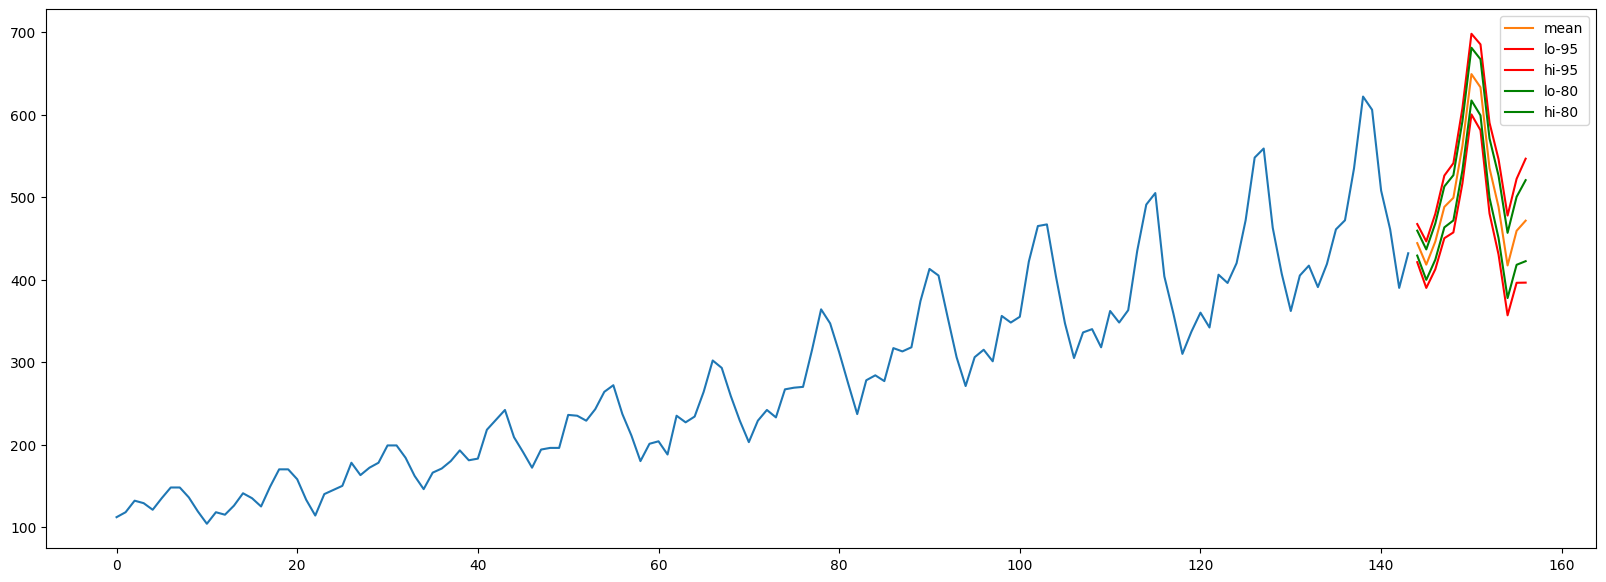

In [37]:
#| hide
_plot_fcst(fcst_arima)

In [38]:
show_doc(AutoARIMA, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L134){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA

>      AutoARIMA (d:Union[int,NoneType]=None, D:Union[int,NoneType]=None,
>                 max_p:int=5, max_q:int=5, max_P:int=2, max_Q:int=2,
>                 max_order:int=5, max_d:int=2, max_D:int=1, start_p:int=2,
>                 start_q:int=2, start_P:int=1, start_Q:int=1,
>                 stationary:bool=False, seasonal:bool=True, ic:str='aicc',
>                 stepwise:bool=True, nmodels:int=94, trace:bool=False,
>                 approximation:Union[bool,NoneType]=False,
>                 method:Union[str,NoneType]=None,
>                 truncate:Union[bool,NoneType]=None, test:str='kpss',
>                 test_kwargs:Union[str,NoneType]=None,
>                 seasonal_test:str='seas',
>                 seasonal_test_kwargs:Union[Dict,NoneType]=None,
>                 allowdrift:bool=False, allowmean:bool=False,
>                 blambda:Union[float,NoneType]=None, biasadj:bool=False,
>                 season_length:int=1, alias:str='AutoARIMA', prediction_interva
>                 ls:Union[statsforecast.utils.ConformalIntervals,NoneType]=None
>                 )

AutoARIMA model.

Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) 
model using an information criterion. Default is Akaike Information Criterion (AICc). 

**Note:**<br>
This implementation is a mirror of Hyndman's [forecast::auto.arima](https://github.com/robjhyndman/forecast).

**References:**<br>
[Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| d | typing.Union[int, NoneType] | None | Order of first-differencing. |
| D | typing.Union[int, NoneType] | None | Order of seasonal-differencing. |
| max_p | int | 5 | Max autorregresives p. |
| max_q | int | 5 | Max moving averages q. |
| max_P | int | 2 | Max seasonal autorregresives P. |
| max_Q | int | 2 | Max seasonal moving averages Q. |
| max_order | int | 5 | Max p+q+P+Q value if not stepwise selection. |
| max_d | int | 2 | Max non-seasonal differences. |
| max_D | int | 1 | Max seasonal differences. |
| start_p | int | 2 | Starting value of p in stepwise procedure. |
| start_q | int | 2 | Starting value of q in stepwise procedure. |
| start_P | int | 1 | Starting value of P in stepwise procedure. |
| start_Q | int | 1 | Starting value of Q in stepwise procedure. |
| stationary | bool | False | If True, restricts search to stationary models. |
| seasonal | bool | True | If False, restricts search to non-seasonal models. |
| ic | str | aicc | Information criterion to be used in model selection. |
| stepwise | bool | True | If True, will do stepwise selection (faster). |
| nmodels | int | 94 | Number of models considered in stepwise search. |
| trace | bool | False | If True, the searched ARIMA models is reported. |
| approximation | typing.Union[bool, NoneType] | False | If True, conditional sums-of-squares estimation, final MLE. |
| method | typing.Union[str, NoneType] | None | Fitting method between maximum likelihood or sums-of-squares. |
| truncate | typing.Union[bool, NoneType] | None | Observations truncated series used in model selection. |
| test | str | kpss | Unit root test to use. See `ndiffs` for details. |
| test_kwargs | typing.Union[str, NoneType] | None | Unit root test additional arguments. |
| seasonal_test | str | seas | Selection method for seasonal differences. |
| seasonal_test_kwargs | typing.Union[typing.Dict, NoneType] | None | Seasonal unit root test arguments. |
| allowdrift | bool | False | If True, drift models terms considered. |
| allowmean | bool | False | If True, non-zero mean models considered. |
| blambda | typing.Union[float, NoneType] | None | Box-Cox transformation parameter. |
| biasadj | bool | False | Use adjusted back-transformed mean Box-Cox. |
| season_length | int | 1 | Number of observations per unit of time. Ex: 24 Hourly data. |
| alias | str | AutoARIMA | Custom name of the model.   |
| prediction_intervals | typing.Union[statsforecast.utils.ConformalIntervals, NoneType] | None | Information to compute conformal prediction intervals.<br>By default, the model will compute the native prediction<br>intervals. |

In [39]:
show_doc(AutoARIMA.fit, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L299){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA.fit

>      AutoARIMA.fit (y:numpy.ndarray, X:Union[numpy.ndarray,NoneType]=None)

Fit the AutoARIMA model.

Fit an AutoARIMA to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (t, ).  |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (t, n_x).  |
| **Returns** |  |  | **AutoARIMA fitted model.** |

In [40]:
show_doc(AutoARIMA.predict, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L364){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA.predict

>      AutoARIMA.predict (h:int, X:Union[numpy.ndarray,NoneType]=None,
>                         level:Union[List[int],NoneType]=None)

Predict with fitted AutoArima.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [41]:
show_doc(AutoARIMA.predict_in_sample, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L401){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA.predict_in_sample

>      AutoARIMA.predict_in_sample (level:Union[Tuple[int],NoneType]=None)

Access fitted AutoArima insample predictions.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| level | typing.Union[typing.Tuple[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [42]:
show_doc(AutoARIMA.forecast, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L421){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA.forecast

>      AutoARIMA.forecast (y:numpy.ndarray, h:int,
>                          X:Union[numpy.ndarray,NoneType]=None,
>                          X_future:Union[numpy.ndarray,NoneType]=None,
>                          level:Union[List[int],NoneType]=None,
>                          fitted:bool=False)

Memory Efficient AutoARIMA predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenpus of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x) optional exogenous.  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| fitted | bool | False | Whether or not returns insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [43]:
show_doc(AutoARIMA.forward, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L515){target="_blank" style="float:right; font-size:smaller"}

### AutoARIMA.forward

>      AutoARIMA.forward (y:numpy.ndarray, h:int,
>                         X:Union[numpy.ndarray,NoneType]=None,
>                         X_future:Union[numpy.ndarray,NoneType]=None,
>                         level:Union[List[int],NoneType]=None,
>                         fitted:bool=False)

Apply fitted ARIMA model to a new time series.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenous of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels for prediction intervals. |
| fitted | bool | False | Whether or not returns insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [44]:
# AutoARIMA's usage example

from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengers as ap

arima = AutoARIMA(season_length=4)
arima = arima.fit(y=ap)
y_hat_dict = arima.predict(h=4, level=[80])
y_hat_dict

{'mean': array([497.95290469, 486.78068657, 500.08214808, 494.1098372 ]),
 'lo-80': 0    467.167463
 1    442.112227
 2    450.786736
 3    440.963293
 Name: 80%, dtype: float64,
 'hi-80': 0    528.738347
 1    531.449146
 2    549.377560
 3    547.256381
 Name: 80%, dtype: float64}

## AutoETS

In [91]:
#| export
class AutoETS(_TS):
    """Automatic Exponential Smoothing model.

    Automatically selects the best ETS (Error, Trend, Seasonality) 
    model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood.
    The state-space equations can be determined based on their $M$ multiplicative, $A$ additive, 
    $Z$ optimized or $N$ ommited components. The `model` string parameter defines the ETS equations: 
    E in [$M, A, Z$], T in [$N, A, M, Z$], and S in [$N, A, M, Z$].
    
    For example when model='ANN' (additive error, no trend, and no seasonality), ETS will 
    explore only a simple exponential smoothing.
    
    If the component is selected as 'Z', it operates as a placeholder to ask the AutoETS model
    to figure out the best parameter.
    
    **Note:**<br>
    This implementation is a mirror of Hyndman's [forecast::ets](https://github.com/robjhyndman/forecast).
    
    **References:**<br>
    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    
    [Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).
    
    Parameters
    ----------
    model : str 
        Controlling state-space-equations.
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    damped : bool 
        A parameter that 'dampens' the trend. 
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals],
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """
    def __init__(
            self, 
            season_length: int = 1,
            model: str = 'ZZZ',
            damped: Optional[bool] = None,
            alias: str = 'AutoETS',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ):
        self.season_length = season_length
        self.model = model
        self.damped = damped
        self.alias = alias
        self.prediction_intervals = prediction_intervals
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the Exponential Smoothing model.

        Fit an Exponential Smoothing model to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters 
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            Exponential Smoothing fitted model.
        """
        self.model_ = ets_f(y, m=self.season_length, model=self.model, damped=self.damped)
        self.model_['actual_residuals'] = y - self.model_['fitted']
        self._store_cs(y=y, X=X)
        return self
    
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None 
        ):
        """Predict with fitted Exponential Smoothing.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional exogenpus of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = forecast_ets(self.model_, h=h, level=level)
        res = {'mean': fcst['mean']}
        if level is None:
            return res
        level = sorted(level)
        if self.prediction_intervals is not None:
            res = self._add_predict_conformal_intervals(res, level)
        else:
            res = {
                **res,
                **{f"lo-{l}": fcst[f"lo-{l}"] for l in reversed(level)},
                **{f"hi-{l}": fcst[f"hi-{l}"] for l in level},
            }
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted Exponential Smoothing insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            residuals = self.model_['actual_residuals']
            se = _calculate_sigma(residuals, len(residuals) - self.model_['n_params'])
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient Exponential Smoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenpus of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mod = ets_f(y, m=self.season_length, model=self.model, damped=self.damped)
        fcst = forecast_ets(mod, h=h, level=level)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        res = {key: fcst[key] for key in keys}
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res,
                    **{f"lo-{l}": fcst[f"lo-{l}"] for l in reversed(level)},
                    **{f"hi-{l}": fcst[f"hi-{l}"] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = _calculate_sigma(y - mod['fitted'], len(y) - mod['n_params'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted Exponential Smoothing model to a new time series.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenpus of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self, 'model_'):
            raise Exception('You have to use the `fit` method first')
        mod = forward_ets(self.model_, y=y)
        fcst = forecast_ets(mod, h=h, level=level)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        res = {key: fcst[key] for key in keys}
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res,
                    **{f"lo-{l}": fcst[f"lo-{l}"] for l in reversed(level)},
                    **{f"hi-{l}": fcst[f"hi-{l}"] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = _calculate_sigma(y - mod['fitted'], len(y) - mod['n_params'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

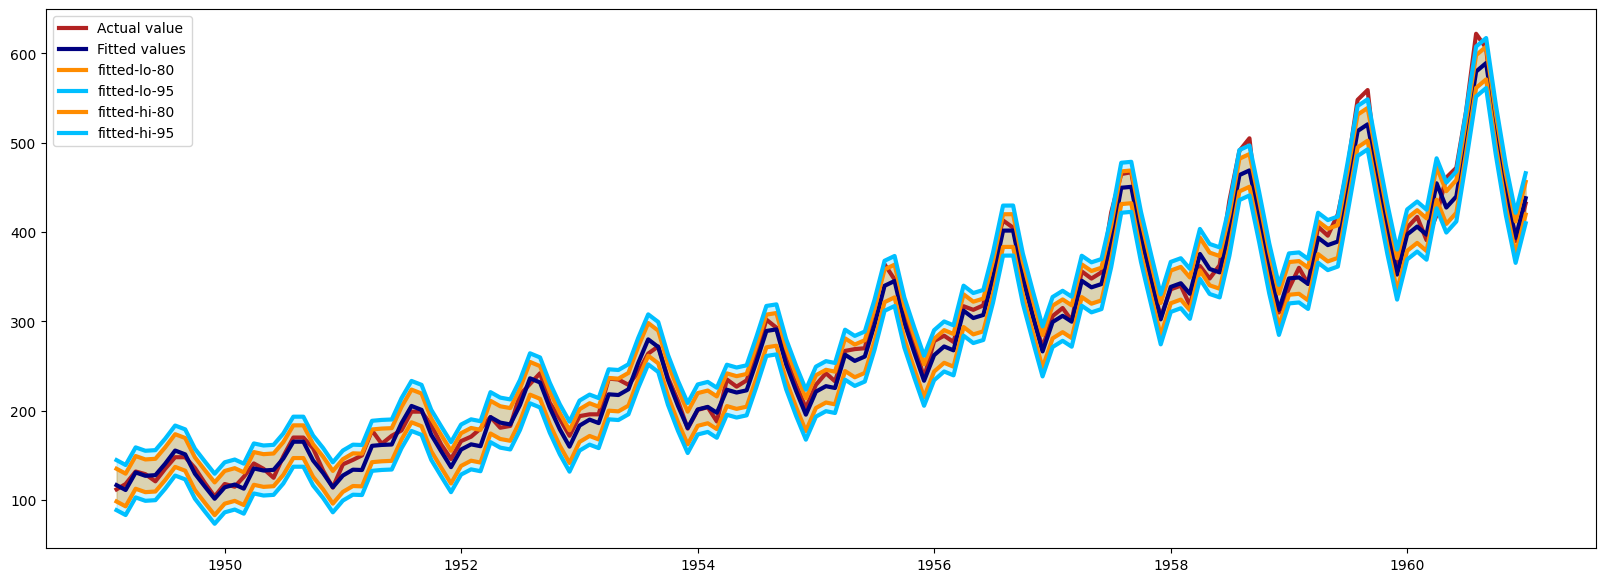

In [92]:
#| hide
autoets = AutoETS(season_length=12)
test_class(autoets, x=ap, h=12, level=[90, 80], test_forward=True)
fcst_ets = autoets.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_ets)

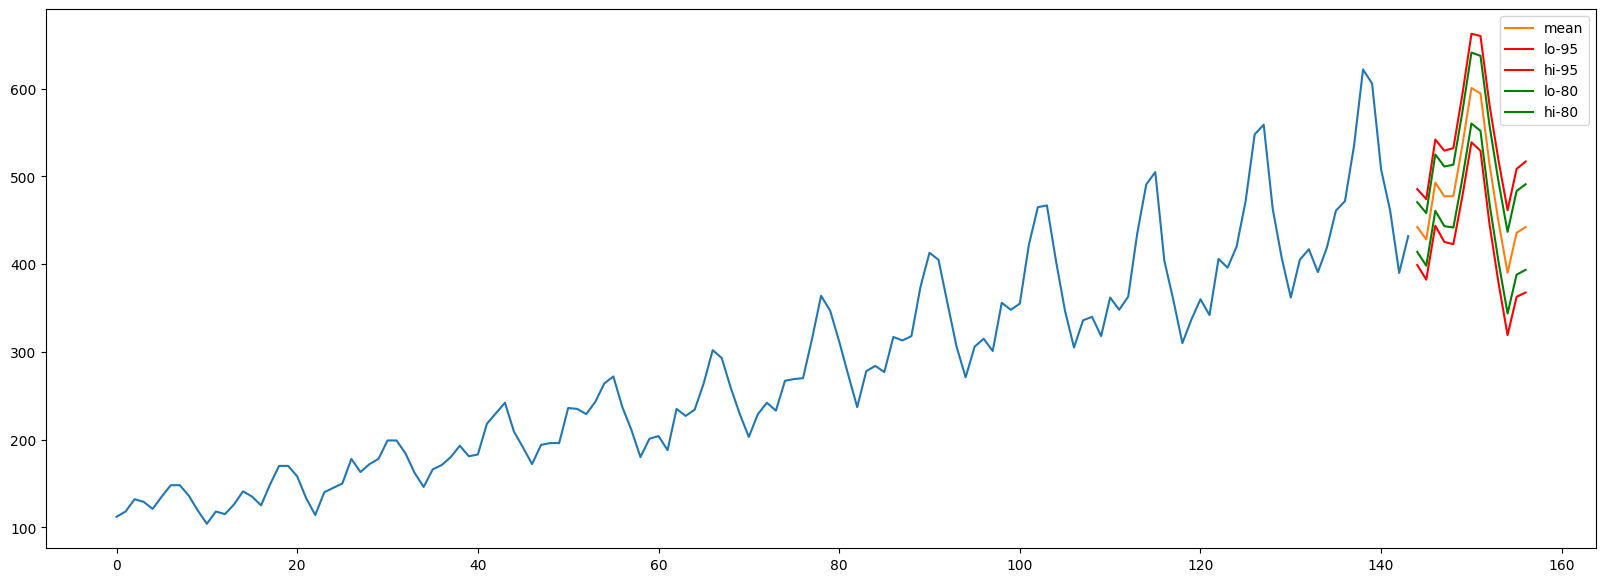

In [93]:
#| hide
_plot_fcst(fcst_ets)

In [94]:
#| hide
#test alias argument
test_eq(
    repr(AutoETS()),
    'AutoETS'
)
test_eq(
    repr(AutoETS(alias='AutoETS_custom')),
    'AutoETS_custom'
)

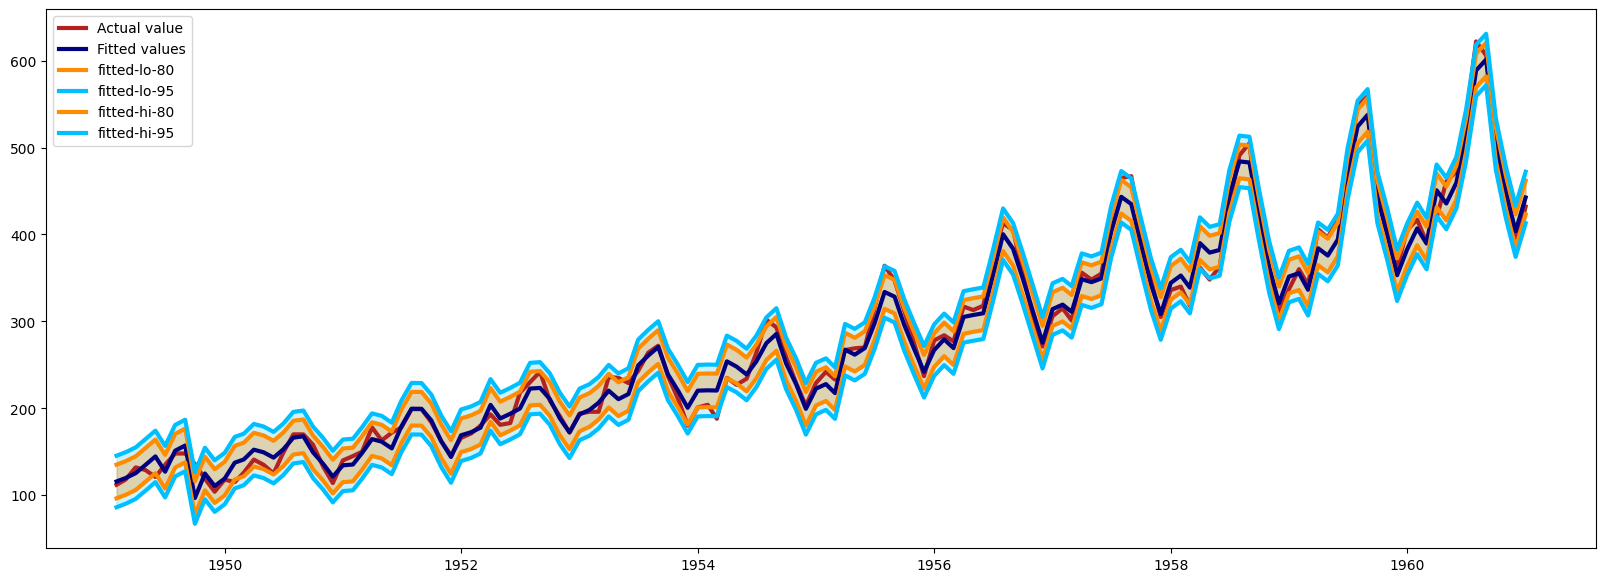

In [95]:
#| hide
autoets = AutoETS(season_length=12, model='AAA')
test_class(autoets, x=ap, h=12, level=[90, 80])
fcst_ets = autoets.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_ets)

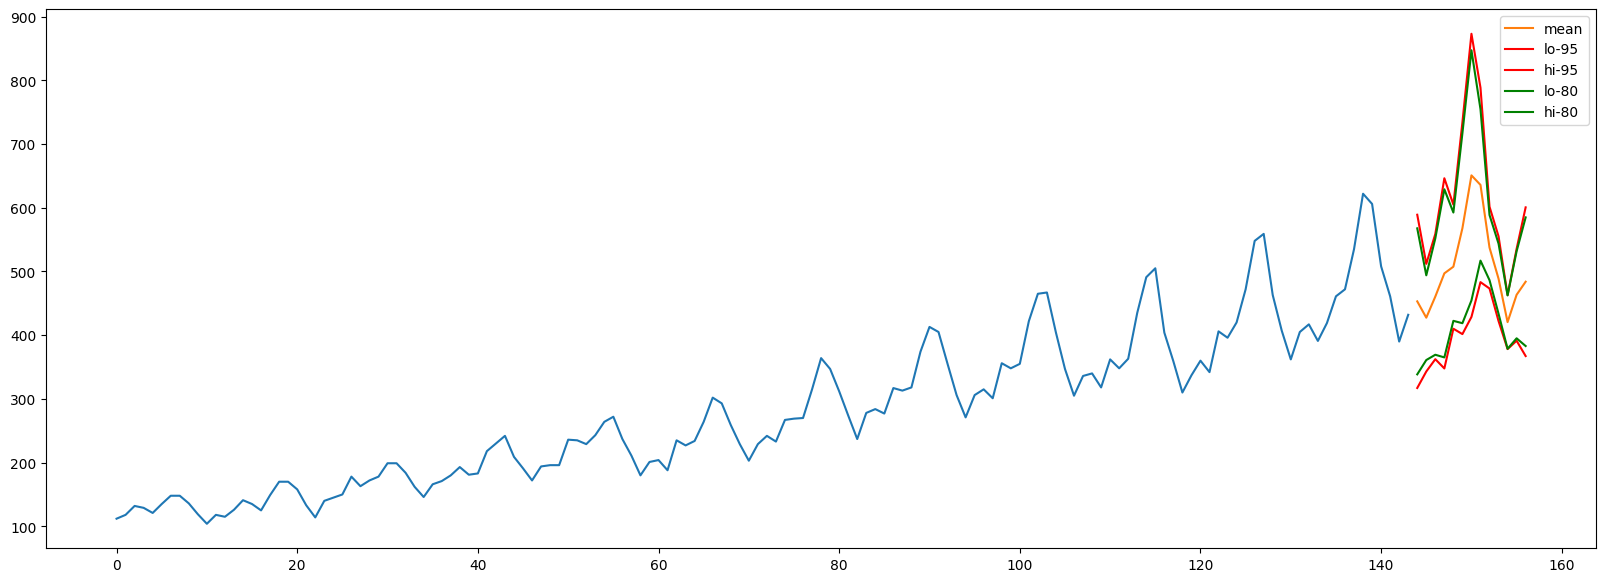

In [96]:
#| hide
# test conformal prediction
autoets_c = AutoETS(season_length=12, model='AAA', prediction_intervals=ConformalIntervals(h=13, n_windows=2))
test_class(autoets_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_ets_c = autoets_c.forecast(ap, 13, None, None, (80,95), True)
test_eq(fcst_ets_c['mean'],
    fcst_ets['mean'])
_plot_fcst(fcst_ets_c)

In [77]:
#| hide
#| hide 
# Test whether forecast and fit-predict generate the same result 
models = ['ANNN', 'AANN', 'ANAN', 'AAAN', 'AAND', 'AAAD', # class 1 
          'MNNN', 'MANN', 'MAND', 'MNAN', 'MAAN', 'MAAD', # class 2 
          'MNMN', 'MAMN', 'MAMD'] # class 3 

for k in range(0,len(models)): 
    mod = models[k][0:3]
    damped_val = models[k][-1]
    if damped_val == 'N': 
        damped = False
    else: 
        damped = True
        
    ets = AutoETS(season_length=12, model=mod, damped=damped) 
    test_class(ets, x=ap, h=13, level=[90, 80], test_forward=True)

In [78]:
show_doc(AutoETS, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L572){target="_blank" style="float:right; font-size:smaller"}

### AutoETS

>      AutoETS (season_length:int=1, model:str='ZZZ',
>               damped:Union[bool,NoneType]=None, alias:str='AutoETS', predictio
>               n_intervals:Union[statsforecast.utils.ConformalIntervals,NoneTyp
>               e]=None)

Automatic Exponential Smoothing model.

Automatically selects the best ETS (Error, Trend, Seasonality) 
model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood.
The state-space equations can be determined based on their $M$ multiplicative, $A$ additive, 
$Z$ optimized or $N$ ommited components. The `model` string parameter defines the ETS equations: 
E in [$M, A, Z$], T in [$N, A, M, Z$], and S in [$N, A, M, Z$].

For example when model='ANN' (additive error, no trend, and no seasonality), ETS will 
explore only a simple exponential smoothing.

If the component is selected as 'Z', it operates as a placeholder to ask the AutoETS model
to figure out the best parameter.

**Note:**<br>
This implementation is a mirror of Hyndman's [forecast::ets](https://github.com/robjhyndman/forecast).

**References:**<br>
[Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

[Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| season_length | int | 1 | Number of observations per unit of time. Ex: 24 Hourly data. |
| model | str | ZZZ | Controlling state-space-equations. |
| damped | typing.Union[bool, NoneType] | None | A parameter that 'dampens' the trend.  |
| alias | str | AutoETS | Custom name of the model. |
| prediction_intervals | typing.Union[statsforecast.utils.ConformalIntervals, NoneType] | None | Information to compute conformal prediction intervals.<br>By default, the model will compute the native prediction<br>intervals. |

In [79]:
show_doc(AutoETS.fit, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L622){target="_blank" style="float:right; font-size:smaller"}

### AutoETS.fit

>      AutoETS.fit (y:numpy.ndarray, X:Union[numpy.ndarray,NoneType]=None)

Fit the Exponential Smoothing model.

Fit an Exponential Smoothing model to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (t, ).  |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (t, n_x).  |
| **Returns** |  |  | **Exponential Smoothing fitted model.** |

In [80]:
show_doc(AutoETS.predict, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L650){target="_blank" style="float:right; font-size:smaller"}

### AutoETS.predict

>      AutoETS.predict (h:int, X:Union[numpy.ndarray,NoneType]=None,
>                       level:Union[List[int],NoneType]=None)

Predict with fitted Exponential Smoothing.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenpus of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [81]:
show_doc(AutoETS.predict_in_sample, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L680){target="_blank" style="float:right; font-size:smaller"}

### AutoETS.predict_in_sample

>      AutoETS.predict_in_sample (level:Union[Tuple[int],NoneType]=None)

Access fitted Exponential Smoothing insample predictions.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| level | typing.Union[typing.Tuple[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [82]:
show_doc(AutoETS.forecast, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L700){target="_blank" style="float:right; font-size:smaller"}

### AutoETS.forecast

>      AutoETS.forecast (y:numpy.ndarray, h:int,
>                        X:Union[numpy.ndarray,NoneType]=None,
>                        X_future:Union[numpy.ndarray,NoneType]=None,
>                        level:Union[List[int],NoneType]=None,
>                        fitted:bool=False)

Memory Efficient Exponential Smoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenpus of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| fitted | bool | False | Whether or not returns insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [83]:
show_doc(AutoETS.forward, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L754){target="_blank" style="float:right; font-size:smaller"}

### AutoETS.forward

>      AutoETS.forward (y:numpy.ndarray, h:int,
>                       X:Union[numpy.ndarray,NoneType]=None,
>                       X_future:Union[numpy.ndarray,NoneType]=None,
>                       level:Union[List[int],NoneType]=None, fitted:bool=False)

Apply fitted Exponential Smoothing model to a new time series.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenpus of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None | Confidence levels for prediction intervals. |
| fitted | bool | False | Whether or not to return insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [84]:
# AutoETS' usage example

from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengers as ap

# Multiplicative trend, optimal error and seasonality
autoets = AutoETS(model='ZMZ',  
              season_length=4)
autoets = autoets.fit(y=ap)
y_hat_dict = autoets.predict(h=4)
y_hat_dict

{'mean': array([416.63294737, 419.65915384, 442.66309931, 457.33314074])}

In [58]:
#| export
class ETS(AutoETS):
    @classmethod
    def _warn(cls):
        warnings.warn(
            '`ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.',
            category=FutureWarning,
            stacklevel=2
        )
        
    def __init__(self, season_length: int = 1, model: str = 'ZZZ', 
                 damped: Optional[bool] = None,
                 alias: str = 'ETS',
                 prediction_intervals: Optional[ConformalIntervals] = None):
        ETS._warn()
        self.season_length = season_length
        self.model = model
        self.damped = damped
        self.alias = alias
        self.prediction_intervals = prediction_intervals
        
    def __repr__(self):
        return self.alias

In [59]:
ets = ETS(model='ZMZ', season_length=4)

/var/folders/w2/91_v34nx0xs2npnl3zsl9tmm0000gn/T/ipykernel_51748/1206872788.py:14: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


In [60]:
#| hide
ets = ETS(model='ZMZ', season_length=4)
autoets = AutoETS(model='ZMZ',  
              season_length=4)
test_eq(ets.forecast(y=ap, h=12)['mean'], 
        autoets.forecast(y=ap, h=12)['mean'])

/var/folders/w2/91_v34nx0xs2npnl3zsl9tmm0000gn/T/ipykernel_51748/1206872788.py:14: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


In [61]:
#| hide
#test alias argument
test_eq(
    repr(ETS()),
    'ETS'
)
test_eq(
    repr(ETS(alias='ETS_custom')),
    'ETS_custom'
)

/var/folders/w2/91_v34nx0xs2npnl3zsl9tmm0000gn/T/ipykernel_51748/1206872788.py:14: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


## AutoCES

In [97]:
#| export
class AutoCES(_TS):
    """Complex Exponential Smoothing model.

    Automatically selects the best Complex Exponential Smoothing
    model using an information criterion. Default is Akaike Information Criterion (AICc), while particular 
    models are estimated using maximum likelihood.
    The state-space equations can be determined based on their $S$ simple, $P$ parial, 
    $Z$ optimized or $N$ ommited components. The `model` string parameter defines the 
    kind of CES model: $N$ for simple CES (withous seasonality), $S$ for simple seasonality (lagged CES),
    $P$ for partial seasonality (without complex part), $F$ for full seasonality (lagged CES
    with real and complex seasonal parts).
    
    If the component is selected as 'Z', it operates as a placeholder to ask the AutoCES model
    to figure out the best parameter.
    
    **References:**<br>
    [Svetunkov, Ivan & Kourentzes, Nikolaos. (2015). "Complex Exponential Smoothing". 10.13140/RG.2.1.3757.2562. ](https://onlinelibrary.wiley.com/doi/full/10.1002/nav.22074).
    
    Parameters
    ----------
    model : str 
        Controlling state-space-equations.
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """
    
    def __init__(
            self, 
            season_length: int = 1,
            model: str = 'Z',
            alias: str = 'CES',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ):
        self.season_length = season_length
        self.model = model
        self.alias = alias
        self.prediction_intervals = prediction_intervals
    
    def __repr__(self):
        return self.alias

    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the Complex Exponential Smoothing model.

        Fit the Complex Exponential Smoothing model to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            Complex Exponential Smoothing fitted model.
        """
        self.model_ = auto_ces(y, m=self.season_length, model=self.model)
        self.model_['actual_residuals'] = y - self.model_['fitted']
        self._store_cs(y=y, X=X)
        return self
    
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None
        ):
        """Predict with fitted Exponential Smoothing.

        Parameters
        ----------
        h : int
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level: List[float] 
            Confidence levels (0-100) for prediction intervals. 
        
        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = forecast_ces(self.model_, h=h, level=level)
        res = {"mean": fcst["mean"]}
        if level is None: 
            return res
        level = sorted(level)
        if self.prediction_intervals is not None:
            res = self._add_predict_conformal_intervals(res, level)
        else:
            res = {
                **res,
                **{f"lo-{l}": fcst[f"lo-{l}"] for l in reversed(level)},
                **{f"hi-{l}": fcst[f"hi-{l}"] for l in level},
            }
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted Exponential Smoothing insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None: 
            residuals = self.model_['actual_residuals']
            se = _calculate_sigma(residuals, self.model_['n'])
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None, 
            fitted: bool = False,
        ):
        """Memory Efficient Complex Exponential Smoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenpus of shape (h, n_x). 
        level: List[float]
            Confidence levels (0-100) for prediction intervals. 
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mod = auto_ces(y, m=self.season_length, model=self.model)
        fcst = forecast_ces(mod, h, level=level)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        res = {key: fcst[key] for key in keys}
        if level is not None: 
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res, 
                    **{f'lo-{l}': fcst[f'lo-{l}'] for l in reversed(level)}, 
                    **{f'hi-{l}': fcst[f'hi-{l}'] for l in level}, 
                }
            if fitted: 
                # add prediction intervals for fitted values 
                se = _calculate_sigma(y - mod['fitted'], len(y)) 
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted Complex Exponential Smoothing to a new time series.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenpus of shape (h, n_x). 
        level: List[float]
            Confidence levels (0-100) for prediction intervals. 
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self, 'model_'):
            raise Exception('You have to use the `fit` method first')
        mod = forward_ces(self.model_, y=y)
        fcst = forecast_ces(mod, h, level=level)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        res = {key: fcst[key] for key in keys}
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
            else:
                res = {
                    **res,
                    **{f'lo-{l}': fcst[f'lo-{l}'] for l in reversed(level)},
                    **{f'hi-{l}': fcst[f'hi-{l}'] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = _calculate_sigma(y - mod['fitted'], len(y))
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

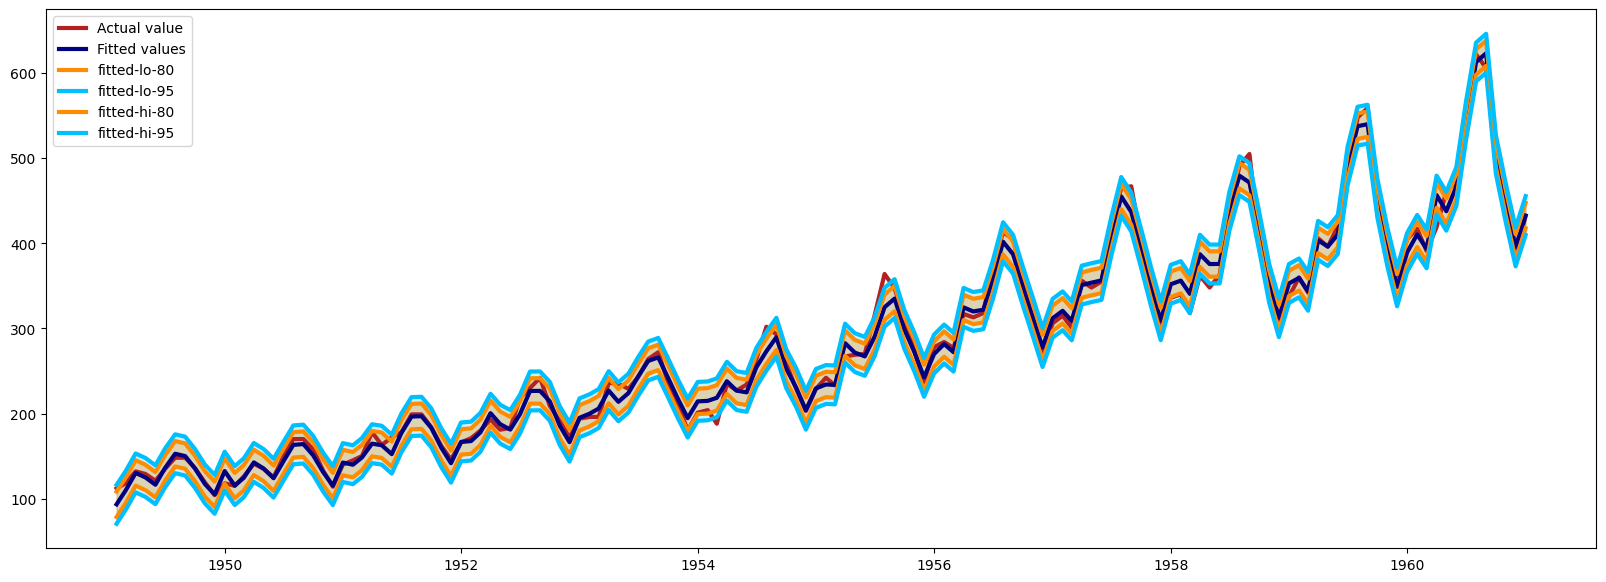

In [98]:
#| hide
autoces = AutoCES(season_length=12)
fcst_ces = autoces.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_ces)

In [99]:
#| hide
# test conformal prediction
autoces_c = AutoCES(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=2)) 
test_class(autoces_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_ces_c = autoces_c.forecast(ap, 13, None, None, (80,95), True)
test_eq(
    fcst_ces["mean"],
    fcst_ces_c["mean"]
)

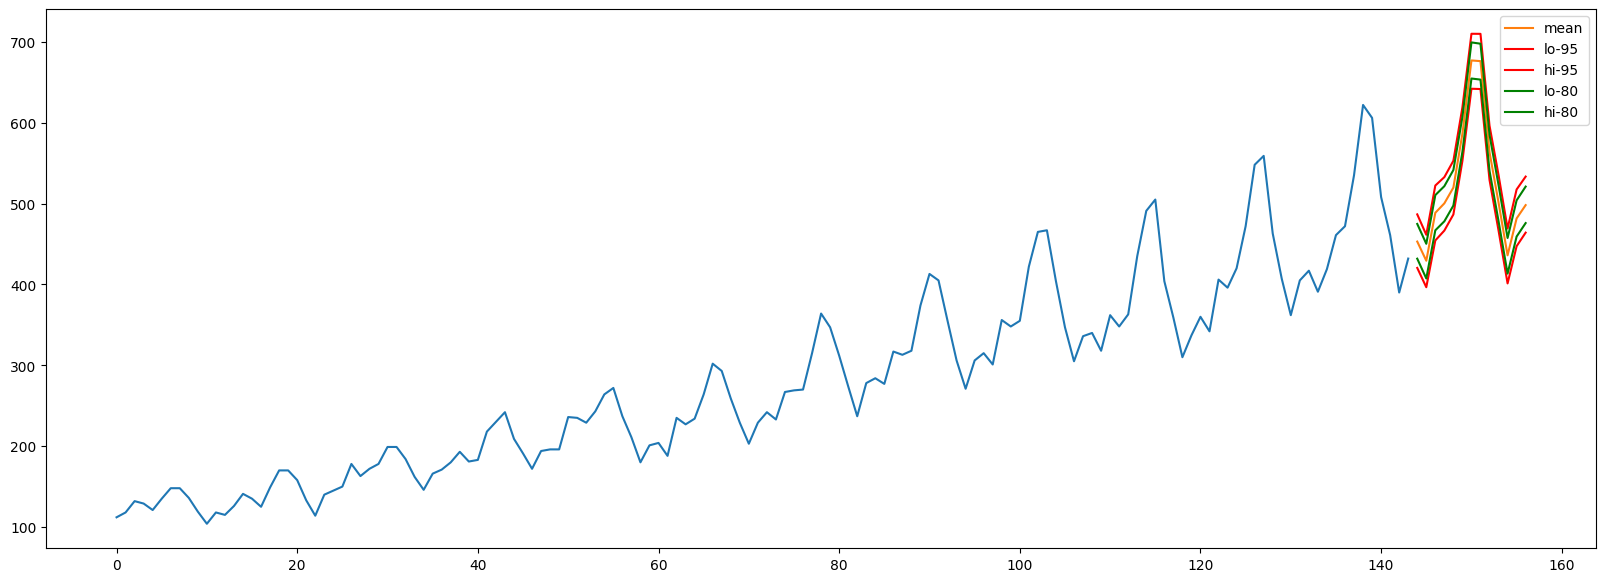

In [100]:
#| hide
_plot_fcst(fcst_ces)

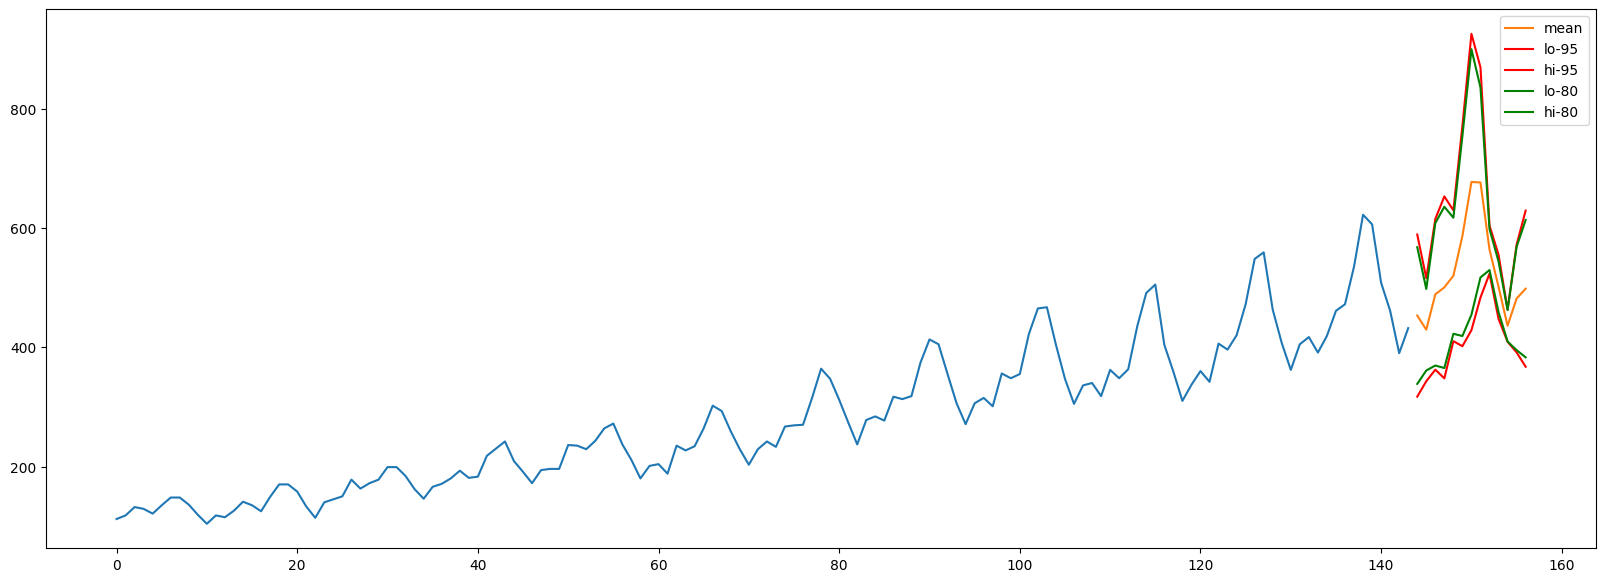

In [101]:
#| hide
_plot_fcst(fcst_ces_c)

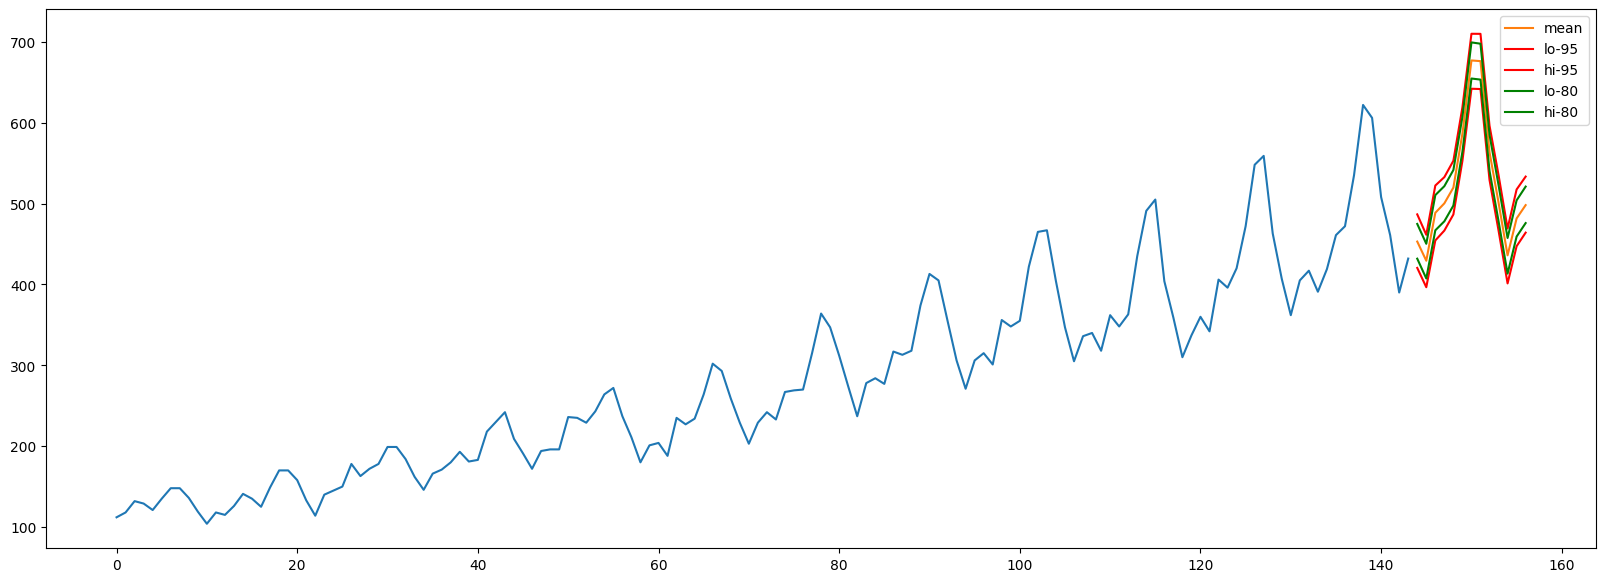

In [102]:
#| hide 
fit = autoces.fit(ap) 
fcst = fit.predict(13, None, (80,95))
_plot_fcst(fit.predict(13, None, (80,95)))

values = ['mean', 'lo-80', 'lo-95', 'hi-80', 'hi-95']
for k in range(0, len(values)): 
    np.testing.assert_equal(
    fcst_ces[values[k]], 
    fcst[values[k]]
)

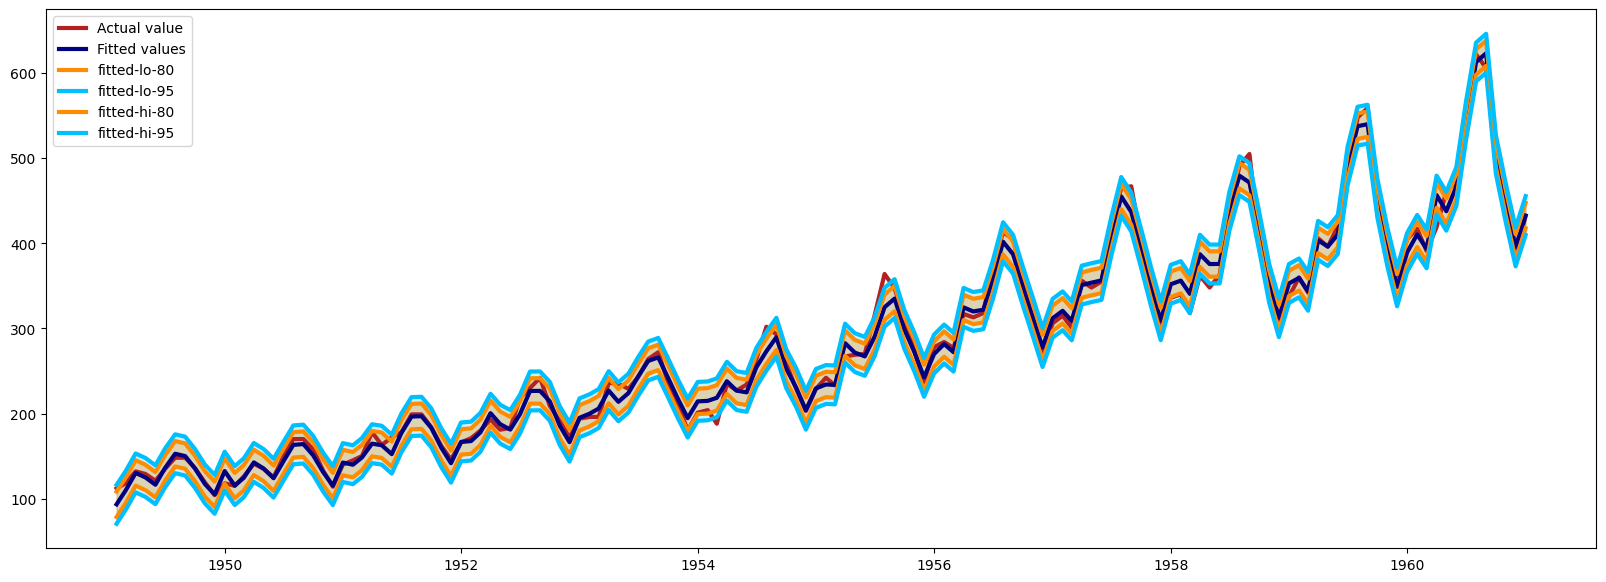

In [103]:
#| hide 
pi_insample = fit.predict_in_sample((80,95))
_plot_insample_pi(pi_insample)

values = ['fitted', 'fitted-lo-80', 'fitted-lo-95', 'fitted-hi-80', 'fitted-hi-95']
for k in range(0, len(values)): 
    np.testing.assert_equal(
    fcst_ces[values[k]], 
    pi_insample[values[k]]
)

In [104]:
#| hide
ces = AutoCES(season_length=12)
test_class(ces, x=ap, h=12, test_forward=True, level=[90, 80])

In [105]:
#| hide
#test alias argument
test_eq(
    repr(AutoCES()),
    'CES'
)
test_eq(
    repr(AutoCES(alias='AutoCES_custom')),
    'AutoCES_custom'
)

In [106]:
show_doc(AutoCES, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L833){target="_blank" style="float:right; font-size:smaller"}

### AutoCES

>      AutoCES (season_length:int=1, model:str='Z', alias:str='CES', prediction_
>               intervals:Union[statsforecast.utils.ConformalIntervals,NoneType]
>               =None)

Complex Exponential Smoothing model.

Automatically selects the best Complex Exponential Smoothing
model using an information criterion. Default is Akaike Information Criterion (AICc), while particular 
models are estimated using maximum likelihood.
The state-space equations can be determined based on their $S$ simple, $P$ parial, 
$Z$ optimized or $N$ ommited components. The `model` string parameter defines the 
kind of CES model: $N$ for simple CES (withous seasonality), $S$ for simple seasonality (lagged CES),
$P$ for partial seasonality (without complex part), $F$ for full seasonality (lagged CES
with real and complex seasonal parts).

If the component is selected as 'Z', it operates as a placeholder to ask the AutoCES model
to figure out the best parameter.

**References:**<br>
[Svetunkov, Ivan & Kourentzes, Nikolaos. (2015). "Complex Exponential Smoothing". 10.13140/RG.2.1.3757.2562. ](https://onlinelibrary.wiley.com/doi/full/10.1002/nav.22074).

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| season_length | int | 1 | Number of observations per unit of time. Ex: 24 Hourly data. |
| model | str | Z | Controlling state-space-equations. |
| alias | str | CES | Custom name of the model. |
| prediction_intervals | typing.Union[statsforecast.utils.ConformalIntervals, NoneType] | None | Information to compute conformal prediction intervals.<br>By default, the model will compute the native prediction<br>intervals. |

In [107]:
show_doc(AutoCES.fit, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L880){target="_blank" style="float:right; font-size:smaller"}

### AutoCES.fit

>      AutoCES.fit (y:numpy.ndarray, X:Union[numpy.ndarray,NoneType]=None)

Fit the Complex Exponential Smoothing model.

Fit the Complex Exponential Smoothing model to a time series (numpy array) `y`
and optionally exogenous variables (numpy array) `X`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (t, ).  |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (t, n_x).  |
| **Returns** |  |  | **Complex Exponential Smoothing fitted model.** |

In [108]:
show_doc(AutoCES.predict, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L908){target="_blank" style="float:right; font-size:smaller"}

### AutoCES.predict

>      AutoCES.predict (h:int, X:Union[numpy.ndarray,NoneType]=None,
>                       level:Union[List[int],NoneType]=None)

Predict with fitted Exponential Smoothing.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenous of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None |  |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [109]:
show_doc(AutoCES.predict_in_sample, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L942){target="_blank" style="float:right; font-size:smaller"}

### AutoCES.predict_in_sample

>      AutoCES.predict_in_sample (level:Union[Tuple[int],NoneType]=None)

Access fitted Exponential Smoothing insample predictions.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| level | typing.Union[typing.Tuple[int], NoneType] | None | Confidence levels (0-100) for prediction intervals. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [110]:
show_doc(AutoCES.forecast, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L962){target="_blank" style="float:right; font-size:smaller"}

### AutoCES.forecast

>      AutoCES.forecast (y:numpy.ndarray, h:int,
>                        X:Union[numpy.ndarray,NoneType]=None,
>                        X_future:Union[numpy.ndarray,NoneType]=None,
>                        level:Union[List[int],NoneType]=None,
>                        fitted:bool=False)

Memory Efficient Complex Exponential Smoothing predictions.

This method avoids memory burden due from object storage.
It is analogous to `fit_predict` without storing information.
It assumes you know the forecast horizon in advance.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenous of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenpus of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None |  |
| fitted | bool | False | Whether or not to return insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [111]:
show_doc(AutoCES.forward, title_level=3)

---

[source](https://github.com/Nixtla/statsforecast/blob/main/statsforecast/models.py#L1020){target="_blank" style="float:right; font-size:smaller"}

### AutoCES.forward

>      AutoCES.forward (y:numpy.ndarray, h:int,
>                       X:Union[numpy.ndarray,NoneType]=None,
>                       X_future:Union[numpy.ndarray,NoneType]=None,
>                       level:Union[List[int],NoneType]=None, fitted:bool=False)

Apply fitted Complex Exponential Smoothing to a new time series.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | ndarray |  | Clean time series of shape (n, ).  |
| h | int |  | Forecast horizon. |
| X | typing.Union[numpy.ndarray, NoneType] | None | Optional insample exogenous of shape (t, n_x).  |
| X_future | typing.Union[numpy.ndarray, NoneType] | None | Optional exogenpus of shape (h, n_x).  |
| level | typing.Union[typing.List[int], NoneType] | None |  |
| fitted | bool | False | Whether or not returns insample predictions. |
| **Returns** | **dict** |  | **Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.** |

In [112]:
# CES' usage example

from statsforecast.models import AutoCES
from statsforecast.utils import AirPassengers as ap

# Multiplicative trend, optimal error and seasonality
ces = AutoCES(model='Z',  
              season_length=4)
ces = ces.fit(y=ap)
y_hat_dict = ces.predict(h=4)
y_hat_dict

{'mean': array([424.30716324, 405.69589186, 442.02640533, 443.63488996])}

## AutoTheta

In [ ]:
#| export
class AutoTheta(_TS):
    """AutoTheta model.

    Automatically selects the best Theta (Standard Theta Model ('STM'),
    Optimized Theta Model ('OTM'), Dynamic Standard Theta Model ('DSTM'),
    Dynamic Optimized Theta Model ('DOTM')) model using mse. 
    
    **References:**<br>
    [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)
    
    Parameters
    ----------
    season_length : int
        Number of observations per unit of time. Ex: 24 Hourly data.
    decomposition_type : str 
        Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
    model : str 
        Controlling Theta Model. By default searchs the best model.
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.    
    """
    def __init__(
        self,
        season_length: int = 1,
        decomposition_type: str = 'multiplicative',
        model: Optional[str] = None,
        alias: str = 'AutoTheta',
        prediction_intervals: Optional[ConformalIntervals] = None,
    ):
        self.season_length = season_length
        self.decomposition_type = decomposition_type
        self.model = model
        self.alias = alias
        self.prediction_intervals = prediction_intervals
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the AutoTheta model.

        Fit an AutoTheta model to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            AutoTheta fitted model.
        """
        self.model_ = auto_theta(y=y, m=self.season_length, 
                                 model=self.model, 
                                 decomposition_type=self.decomposition_type)
        self.model_['fitted'] = y - self.model_['residuals']
        self._store_cs(y, X)
        return self
    
    def predict(
            self, 
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
        ):
        """Predict with fitted AutoTheta.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = forecast_theta(self.model_, h=h, level=level)
        if self.prediction_intervals is not None and level is not None:
            fcst = self._add_predict_conformal_intervals(fcst, level)
        return fcst
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted AutoTheta insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            se = np.std(self.model_['residuals'][3:], ddof=1)
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient AutoTheta predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mod = auto_theta(
            y=y, 
            m=self.season_length, 
            model=self.model, 
            decomposition_type=self.decomposition_type
        )
        res = forecast_theta(mod, h, level=level)
        if self.prediction_intervals is not None:
            res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
        if fitted:
            res['fitted'] = y - mod['residuals']
        if level is not None and fitted:
            # add prediction intervals for fitted values
            se = np.std(mod['residuals'][3:], ddof=1)
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted AutoTheta to a new time series.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self, 'model_'):
            raise Exception('You have to use the `fit` method first')
        mod = forward_theta(self.model_, y=y)
        res = forecast_theta(mod, h, level=level)
        if self.prediction_intervals is not None:
            res = self._add_conformal_intervals(fcst=res, y=y, X=X, level=level)
        if fitted:
            res['fitted'] = y - mod['residuals']
        if level is not None and fitted:
            # add prediction intervals for fitted values
            se = np.std(mod['residuals'][3:], ddof=1)
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res

In [ ]:
#| hide
theta = AutoTheta(season_length=12)
test_class(theta, x=ap, h=12, level=[80, 90], test_forward=True)
fcst_theta = theta.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_theta)

In [ ]:
#| hide
# test conformal prediction
theta_c = AutoTheta(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=2)) 
test_class(theta_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_theta_c = theta_c.forecast(ap, 13, None, None, (80,95), True)
test_eq(
    fcst_theta_c['mean'],
    fcst_theta['mean'],
)

In [ ]:
#| hide
_plot_fcst(fcst_theta_c)

In [ ]:
#| hide
zero_theta = theta.forward(np.zeros(10), h=12, level=[80, 90], fitted=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(AutoTheta()),
    'AutoTheta'
)
test_eq(
    repr(AutoTheta(alias='AutoTheta_custom')),
    'AutoTheta_custom'
)

In [ ]:
show_doc(AutoTheta, title_level=3)

In [ ]:
show_doc(AutoTheta.fit, title_level=3)

In [ ]:
show_doc(AutoTheta.predict, title_level=3)

In [ ]:
show_doc(AutoTheta.predict_in_sample, title_level=3)

In [ ]:
show_doc(AutoTheta.forecast, title_level=3)

In [ ]:
show_doc(AutoTheta.forward, title_level=3)

In [ ]:
# AutoTheta's usage example

from statsforecast.models import AutoTheta
from statsforecast.utils import AirPassengers as ap


theta = AutoTheta(season_length=4)
theta = theta.fit(y=ap)
y_hat_dict = theta.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> ARIMA family </span>

## ARIMA

In [ ]:
#| export
class ARIMA(_TS):
    """ARIMA model.

    AutoRegressive Integrated Moving Average model.

    **References:**<br>
    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    
    Parameters
    ----------
    order : tuple (default=(0, 0, 0))
        A specification of the non-seasonal part of the ARIMA model: the three components (p, d, q) are the AR order, the degree of differencing, and the MA order.
    season_length : int (default=1)
        Number of observations per unit of time. Ex: 24 Hourly data.
    seasonal_order : tuple (default=(0, 0, 0))
        A specification of the seasonal part of the ARIMA model.
        (P, D, Q) for the  AR order, the degree of differencing, the MA order.
    include_mean : bool (default=True)
        Should the ARIMA model include a mean term? 
        The default is True for undifferenced series, False for differenced ones (where a mean would not affect the fit nor predictions).
    include_drift : bool (default=False)
        Should the ARIMA model include a linear drift term? 
        (i.e., a linear regression with ARIMA errors is fitted.)
    include_constant : bool, optional (default=None)
        If True, then includ_mean is set to be True for undifferenced series and include_drift is set to be True for differenced series. 
        Note that if there is more than one difference taken, no constant is included regardless of the value of this argument. 
        This is deliberate as otherwise quadratic and higher order polynomial trends would be induced.
    blambda : float, optional (default=None)
        Box-Cox transformation parameter.
    biasadj : bool (default=False)
        Use adjusted back-transformed mean Box-Cox.
    method : str (default='CSS-ML')
        Fitting method: maximum likelihood or minimize conditional sum-of-squares. 
        The default (unless there are missing values) is to use conditional-sum-of-squares to find starting values, then maximum likelihood.
    fixed : dict, optional (default=None)
        Dictionary containing fixed coefficients for the arima model. Example: `{'ar1': 0.5, 'ma2': 0.75}`.
        For autoregressive terms use the `ar{i}` keys. For its seasonal version use `sar{i}`.
        For moving average terms use the `ma{i}` keys. For its seasonal version use `sma{i}`.
        For intercept and drift use the `intercept` and `drift` keys.
        For exogenous variables use the `ex_{i}` keys.
    alias : str
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """
    def __init__(
        self,
        order: Tuple[int, int, int] = (0, 0, 0),
        season_length: int = 1,
        seasonal_order: Tuple[int, int, int] = (0, 0, 0),
        include_mean: bool = True,
        include_drift: bool = False,
        include_constant: Optional[bool] = None,
        blambda: Optional[float] = None,
        biasadj: bool = False,
        method: str = 'CSS-ML',
        fixed: Optional[dict] = None, 
        alias: str = 'ARIMA',
        prediction_intervals: Optional[ConformalIntervals] = None,
    ):
        self.order=order
        self.season_length=season_length
        self.seasonal_order=seasonal_order
        self.include_mean=include_mean
        self.include_drift=include_drift
        self.include_constant=include_constant
        self.blambda=blambda
        self.biasadj=biasadj
        self.method=method
        self.fixed=fixed
        self.alias=alias
        self.prediction_intervals=prediction_intervals
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """
        Fit the model to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            Fitted model.
        """
        with np.errstate(invalid='ignore'):
            self.model_ = Arima(
                x=y,
                order=self.order,
                seasonal={'order': self.seasonal_order, 
                          'period': self.season_length},
                xreg=X,
                include_mean=self.include_mean,
                include_constant=self.include_constant,
                include_drift=self.include_drift,
                blambda=self.blambda,
                biasadj=self.biasadj,
                method=self.method,
                fixed=self.fixed
            )
        if self.prediction_intervals is not None:
            self._cs = self._conformity_scores(y=y, X=X)
        return self
    
    def predict(
            self, 
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
        ):
        """Predict with fitted model.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = forecast_arima(self.model_, h=h, xreg=X, level=level)
        mean = fcst['mean']
        res = {'mean': mean}
        if level is None:
            return res
        level = sorted(level)
        if self.prediction_intervals is not None:
            res = self._conformal_method(fcst=res, cs=self._cs, level=level)
            return res
        return {
            'mean': mean,
            **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
            **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
        }
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = fitted_arima(self.model_)
        res = {'fitted': mean}
        if level is not None:
            se = np.sqrt(self.model_['sigma2'])
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory efficient predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x) optional exogenous. 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        with np.errstate(invalid='ignore'):
            mod = Arima(
                x=y,
                order=self.order,
                seasonal={'order': self.seasonal_order, 
                          'period': self.season_length},
                xreg=X,
                include_mean=self.include_mean,
                include_constant=self.include_constant,
                include_drift=self.include_drift,
                blambda=self.blambda,
                biasadj=self.biasadj,
                method=self.method,
                fixed=self.fixed
            )
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        res = {'mean': fcst['mean']}
        if fitted:
            res['fitted'] = fitted_arima(mod)
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                cs = self._conformity_scores(y=y, X=X)
                res = self._conformal_method(fcst=res, cs=cs, level=level)
            else:
                res = {
                    **res,
                    **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                    **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = np.sqrt(mod['sigma2'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted model to a new time series.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self, 'model_'):
            raise Exception('You have to use the `fit` method first')
        with np.errstate(invalid='ignore'):
            mod = forward_arima(self.model_, y=y, xreg=X, method=self.method)
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        res = {'mean': fcst['mean']}
        if fitted:
            res['fitted'] = fitted_arima(mod)
        if level is not None:
            level = sorted(level)
            if self.prediction_intervals is not None:
                cs = self._conformity_scores(y=y, X=X)
                res = self._conformal_method(fcst=res, cs=cs, level=level)
            else:
                res = {
                    **res,
                    **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
                    **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
                }
            if fitted:
                # add prediction intervals for fitted values
                se = np.sqrt(mod['sigma2'])
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

In [ ]:
#| hide
simple_arima = ARIMA(order=(1, 0, 0), season_length=12) 
test_class(simple_arima, x=ap, h=12, level=[90, 80], test_forward=True)
fcst_simple_arima = simple_arima.forecast(ap, 13, None, None, (80,95), True)
_plot_insample_pi(fcst_simple_arima)

In [ ]:
#| hide
# test conformal prediction
simple_arima_c = ARIMA(order=(1, 0, 0), season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(simple_arima_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_simple_arima_c = simple_arima_c.forecast(ap, 13, None, None, (80,95), True)

In [ ]:
#| hide
test_eq(
    fcst_simple_arima_c['mean'],
    fcst_simple_arima['mean'],
)

In [ ]:
#| hide
_plot_fcst(fcst_simple_arima_c)

In [ ]:
#| hide
simple_arima = ARIMA(order=(2, 0, 0), season_length=12, fixed={'ar1': 0.5, 'ar2': 0.5}) 
test_class(simple_arima, x=ap, h=12, level=[90, 80], test_forward=True)
fcst_simple_arima = simple_arima.forecast(ap, 4, None, None, (80,95), True)
_plot_insample_pi(fcst_simple_arima)
test_eq(
    fcst_simple_arima['mean'],
    np.array([411., 421.5, 416.25, 418.875])
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(ARIMA()),
    'ARIMA'
)
test_eq(
    repr(ARIMA(alias='ARIMA_seasonality')),
    'ARIMA_seasonality'
)

In [ ]:
show_doc(ARIMA, title_level=3)

In [ ]:
show_doc(ARIMA.fit, title_level=3)

In [ ]:
show_doc(ARIMA.predict, title_level=3)

In [ ]:
show_doc(ARIMA.predict_in_sample, title_level=3)

In [ ]:
show_doc(ARIMA.forecast, title_level=3)

In [ ]:
show_doc(ARIMA.forward, title_level=3)

In [ ]:
# ARIMA's usage example

from statsforecast.models import ARIMA
from statsforecast.utils import AirPassengers as ap


arima = ARIMA(order=(1, 0, 0), season_length=12)
arima = arima.fit(y=ap)
y_hat_dict = arima.predict(h=4, level=[80])
y_hat_dict

## AutoRegressive

In [ ]:
#| export
class AutoRegressive(ARIMA):
    """Simple Autoregressive model.

    Parameters
    ----------
    lags : int or list 
        Number of lags to include in the model. 
        If an int is passed then all lags up to `lags` are considered.
        If a list, only the elements of the list are considered as lags.
    include_mean : bool (default=True)
        Should the AutoRegressive model include a mean term? 
        The default is True for undifferenced series, False for differenced ones (where a mean would not affect the fit nor predictions).
    include_drift : bool (default=False)
        Should the AutoRegressive model include a linear drift term? 
        (i.e., a linear regression with AutoRegressive errors is fitted.)
    blambda : float, optional (default=None)
        Box-Cox transformation parameter.
    biasadj : bool (default=False)
        Use adjusted back-transformed mean Box-Cox.
    method : str (default='CSS-ML')
        Fitting method: maximum likelihood or minimize conditional sum-of-squares. 
        The default (unless there are missing values) is to use conditional-sum-of-squares to find starting values, then maximum likelihood.
    fixed : dict, optional (default=None)
        Dictionary containing fixed coefficients for the AutoRegressive model. Example: `{'ar1': 0.5, 'ar5': 0.75}`.
        For autoregressive terms use the `ar{i}` keys.
    alias : str
        Custom name of the model.  
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """
    def __init__(
        self,
        lags: Tuple[int, List],
        include_mean: bool = True,
        include_drift: bool = False,
        blambda: Optional[float] = None,
        biasadj: bool = False,
        method: str = 'CSS-ML',
        fixed: Optional[dict] = None, 
        alias: str = 'AutoRegressive',
        prediction_intervals: Optional[ConformalIntervals] = None,
    ):
        if isinstance(lags, int):
            order = (lags, 0, 0)
        elif isinstance(lags, list):
            order = (max(lags), 0, 0)
            fixed_lags = {f'ar{i+1}': np.nan if (i+1) in lags else 0 for i in range(max(lags))}
            if fixed is not None:
                fixed_lags.update(fixed)
            fixed = fixed_lags
        else:
            raise ValueError('Please provide an int or a list specifying the lags to use.')
        super().__init__(
            order=order,
            include_mean=include_mean, 
            include_drift=include_drift,
            blambda=blambda,
            biasadj=biasadj,
            method=method,
            alias=alias,
            fixed=fixed,
            prediction_intervals=prediction_intervals,
        )

    def __repr__(self):
        return self.alias
    
 

In [ ]:
#| hide
ar = AutoRegressive(lags=[12], fixed={'ar12': 0.9999999}) 
test_class(ar, x=ap, h=12, level=[90, 80], test_forward=True)
fcst_ar = ar.forecast(ap, 13, None, None, (80,95), True)
# we should recover seasonal naive
test_close(
    fcst_ar['mean'][:-1],
    ap[-12:], 
    eps=1e-4
)
_plot_insample_pi(fcst_simple_arima)

In [ ]:
#| hide
# test conformal prediction
ar_c = AutoRegressive(lags=[12], fixed={'ar12': 0.9999999}, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(ar_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_ar_c = ar_c.forecast(ap, 13, None, None, (80,95), True)

In [ ]:
#| hide
test_eq(
    fcst_ar_c['mean'],
    fcst_ar['mean'],
)

In [ ]:
#| hide
_plot_fcst(fcst_ar_c)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(AutoRegressive(lags=[12])),
    'AutoRegressive'
)
test_eq(
    repr(AutoRegressive(lags=[12], alias='AutoRegressive_lag12')),
    'AutoRegressive_lag12'
)

In [ ]:
show_doc(AutoRegressive, title_level=3)

In [ ]:
show_doc(AutoRegressive.fit, title_level=3, name='AutoRegressive.fit')

In [ ]:
show_doc(AutoRegressive.predict, title_level=3, name='AutoRegressive.predict')

In [ ]:
show_doc(AutoRegressive.predict_in_sample, title_level=3, name='AutoRegressive.predict_in_sample')

In [ ]:
show_doc(AutoRegressive.forecast, title_level=3, name='AutoRegressive.forecast')

In [ ]:
show_doc(AutoRegressive.forward, title_level=3, name='AutoRegressive.forward')

In [ ]:
# AutoRegressive's usage example

from statsforecast.models import AutoRegressive
from statsforecast.utils import AirPassengers as ap


ar = AutoRegressive(lags=[12])
ar = ar.fit(y=ap)
y_hat_dict = ar.predict(h=4, level=[80])
y_hat_dict

# <span style="color:DarkBlue"> ExponentialSmoothing </span>

## SimpleSmooth

In [ ]:
#| export
@njit
def _ses_fcst_mse(x: np.ndarray, alpha: float) -> Tuple[float, float, np.ndarray]:
    """Perform simple exponential smoothing on a series.

    This function returns the one step ahead prediction
    as well as the mean squared error of the fit.
    """
    smoothed = x[0]
    n = x.size
    mse = 0.
    fitted = np.full(n, np.nan, np.float32)

    for i in range(1, n):
        smoothed = (alpha * x[i - 1] + (1 - alpha) * smoothed).item()
        error = x[i] - smoothed
        mse += error * error
        fitted[i] = smoothed

    mse /= n
    forecast = alpha * x[-1] + (1 - alpha) * smoothed
    return forecast, mse, fitted


def _ses_mse(alpha: float, x: np.ndarray) -> float:
    """Compute the mean squared error of a simple exponential smoothing fit."""
    _, mse, _ = _ses_fcst_mse(x, alpha)
    return mse


@njit
def _ses_forecast(x: np.ndarray, alpha: float) -> Tuple[float, np.ndarray]:
    """One step ahead forecast with simple exponential smoothing."""
    forecast, _, fitted = _ses_fcst_mse(x, alpha)
    return forecast, fitted


@njit
def _demand(x: np.ndarray) -> np.ndarray:
    """Extract the positive elements of a vector."""
    return x[x > 0]


@njit
def _intervals(x: np.ndarray) -> np.ndarray:
    """Compute the intervals between non zero elements of a vector."""
    y = []

    ctr = 1
    for val in x:
        if val == 0:
            ctr += 1
        else:
            y.append(ctr)
            ctr = 1

    return np.array(y)


@njit
def _probability(x: np.ndarray) -> np.ndarray:
    """Compute the element probabilities of being non zero."""
    return (x != 0).astype(np.int32)


def _optimized_ses_forecast(
        x: np.ndarray,
        bounds: Sequence[Tuple[float, float]] = [(0.1, 0.3)]
    ) -> Tuple[float, np.ndarray]:
    """Searches for the optimal alpha and computes SES one step forecast."""
    alpha = minimize(
        fun=_ses_mse,
        x0=(0,),
        args=(x,),
        bounds=bounds,
        method='L-BFGS-B'
    ).x[0]
    forecast, fitted = _ses_forecast(x, alpha)
    return forecast, fitted


@njit
def _chunk_sums(array: np.ndarray, chunk_size: int) -> np.ndarray:
    """Splits an array into chunks and returns the sum of each chunk."""
    n = array.size
    n_chunks = n // chunk_size
    sums = np.empty(n_chunks)
    for i, start in enumerate(range(0, n, chunk_size)):
        sums[i] = array[start : start + chunk_size].sum()
    return sums

In [ ]:
#| exporti
@njit
def _ses(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        alpha: float, # smoothing parameter
    ): 
    fcst, _, fitted_vals = _ses_fcst_mse(y, alpha)
    mean = _repeat_val(val=fcst, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SimpleExponentialSmoothing(_TS):
    """SimpleExponentialSmoothing model.

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1}$

    The rate $0 \leq \\alpha \leq 1$ at which the weights decrease is called the smoothing parameter. When $\\alpha = 1$, SES is equal to the naive method.

    **References:**<br>
    [Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

    Parameters
    ----------
    alpha : float 
        Smoothing parameter.
    alias : str 
        Custom name of the model. 
    """
    def __init__(
            self, 
            alpha: float,
            alias: str = 'SES'
        ):
        self.alpha = alpha
        self.alias = alias
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SimpleExponentialSmoothing model.

        Fit an SimpleExponentialSmoothing to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            SimpleExponentialSmoothing fitted model.
        """
        mod = _ses(y=y, alpha=self.alpha, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted SimpleExponentialSmoothing.

        Parameters
        ----------
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SimpleExponentialSmoothing insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
            
        """
        res = {'fitted': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SimpleExponentialSmoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _ses(y=y, h=h, fitted=fitted, alpha=self.alpha)
        return out

In [ ]:
#| hide
ses = SimpleExponentialSmoothing(alpha=0.1)
test_class(ses, x=ap, h=12)
#more tests
ses = ses.fit(ap)
fcst_ses = ses.predict(12)
test_close(fcst_ses['mean'], np.repeat(460.3028, 12), eps=1e-4)
#to recover these residuals from R
#you have to pass initial="simple"
#in the `ses` function
np.testing.assert_allclose(
    ses.predict_in_sample()['fitted'][[0, 1, -1]], 
    np.array([np.nan, 118 - 6., 432 + 31.447525])
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SimpleExponentialSmoothing(alpha=0.1)),
    'SES'
)
test_eq(
    repr(SimpleExponentialSmoothing(alpha=0.1, alias='SES_custom')),
    'SES_custom'
)

In [ ]:
show_doc(SimpleExponentialSmoothing, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothing.forecast, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothing.fit, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothing.predict, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothing.predict_in_sample, title_level=3)

In [ ]:
# SimpleExponentialSmoothing's usage example

from statsforecast.models import SimpleExponentialSmoothing
from statsforecast.utils import AirPassengers as ap


ses = SimpleExponentialSmoothing(alpha=0.5)
ses = ses.fit(y=ap)
y_hat_dict = ses.predict(h=4)
y_hat_dict

## SimpleSmoothOptimized

In [ ]:
#| exporti
def _ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    fcst_, fitted_vals = _optimized_ses_forecast(y, [(0.01, 0.99)])
    mean = _repeat_val(val=fcst_, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SimpleExponentialSmoothingOptimized(_TS):
    """SimpleExponentialSmoothing model.

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1}$

    The smoothing parameter $\\alpha^*$ is optimized by square error minimization.

    **References:**<br>
    [Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

    Parameters
    ----------
    alias: str 
        Custom name of the model.   
    """
    def __init__(self, alias: str = 'SESOpt'):
        self.alias = alias
    
    def __repr__(self):
        return self.alias

    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SimpleExponentialSmoothingOptimized model.

        Fit an SimpleExponentialSmoothingOptimized to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            SimpleExponentialSmoothingOptimized fitted model.
        """
        mod = _ses_optimized(y=y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self

    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted SimpleExponentialSmoothingOptimized.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x).

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res

    def predict_in_sample(self):
        """Access fitted SimpleExponentialSmoothingOptimized insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        return res

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SimpleExponentialSmoothingOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _ses_optimized(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
ses_op = SimpleExponentialSmoothingOptimized()
test_class(ses_op, x=ap, h=12)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SimpleExponentialSmoothingOptimized()),
    'SESOpt'
)
test_eq(
    repr(SimpleExponentialSmoothingOptimized(alias='SESOpt_custom')),
    'SESOpt_custom'
)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.fit, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.predict, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.predict_in_sample, title_level=3)

In [ ]:
show_doc(SimpleExponentialSmoothingOptimized.forecast, title_level=3)

In [ ]:
# SimpleExponentialSmoothingOptimized's usage example

from statsforecast.models import SimpleExponentialSmoothingOptimized
from statsforecast.utils import AirPassengers as ap


seso = SimpleExponentialSmoothingOptimized()
seso = seso.fit(y=ap)
y_hat_dict = seso.predict(h=4)
y_hat_dict

## SeasonalSmooth

In [ ]:
#| exporti
@njit
def _seasonal_exponential_smoothing(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        season_length: int, # length of season
        alpha: float, # smoothing parameter
    ):
    n = y.size
    if n < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        init_idx = (i + n % season_length)
        season_vals[i], fitted_vals[init_idx::season_length] = _ses_forecast(y[init_idx::season_length], alpha)
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SeasonalExponentialSmoothing(_TS):
    """SeasonalExponentialSmoothing model.

    Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
    Suitable for data with no clear trend or seasonality. 
    Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
    $\hat{y}_{t+1,s} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1,s}$

    **Note:**<br>
    This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
    And a single seasonal smoothing parameter $\\alpha$ is shared across seasons.

    **References:**<br>
    [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

    [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).

    Parameters
    ----------
    alpha : float 
        Smoothing parameter.
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    alias : str 
        Custom name of the model.   
    """
    def __init__(
            self, 
            season_length: int,
            alpha: float,
            alias: str = 'SeasonalES'
        ):
        self.season_length = season_length
        self.alpha = alpha
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SeasonalExponentialSmoothing model.

        Fit an SeasonalExponentialSmoothing to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            SeasonalExponentialSmoothing fitted model.
        """
        mod = _seasonal_exponential_smoothing(
            y=y, 
            season_length=self.season_length, 
            alpha=self.alpha,
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted SeasonalExponentialSmoothing.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalExponentialSmoothing insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalExponentialSmoothing predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x).
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _seasonal_exponential_smoothing(
            y=y, h=h, fitted=fitted, 
            alpha=self.alpha,
            season_length=self.season_length
        )
        return out

In [ ]:
#| hide
seas_es = SeasonalExponentialSmoothing(season_length=12, alpha=1.)
test_class(seas_es, x=ap, h=12)
test_eq(seas_es.predict_in_sample()['fitted'][-3:],  np.array([461 - 54., 390 - 28., 432 - 27.]))

In [ ]:
#| hide
# test we can recover the expected seasonality
test_eq(
    seas_es.forecast(ap[4:], h=12)['mean'],
    seas_es.forecast(ap, h=12)['mean']
)

In [ ]:
#| hide
# test close to seasonal naive
for i in range(1, 13):
    test_close(
        ap[i:][-12:],
        seas_es.forecast(ap[i:], h=12)['mean'],
    )

In [ ]:
plt.plot(np.concatenate([ap[6:], seas_es.forecast(ap[6:], h=12)['mean']]))

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SeasonalExponentialSmoothing(season_length=12, alpha=1.)),
    'SeasonalES'
)
test_eq(
    repr(SeasonalExponentialSmoothing(season_length=12, alpha=1., alias='SeasonalES_custom')),
    'SeasonalES_custom'
)

In [ ]:
show_doc(SeasonalExponentialSmoothing, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothing.fit, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothing.predict, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothing.predict_in_sample, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothing.forecast, title_level=3)

In [ ]:
# SeasonalExponentialSmoothing's usage example

from statsforecast.models import SeasonalExponentialSmoothing
from statsforecast.utils import AirPassengers as ap


model = SeasonalExponentialSmoothing(alpha=0.5, season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## SeasonalSmoothOptimized

In [ ]:
#| exporti
def _seasonal_ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool , # fitted values
        season_length: int, # season length
    ): 
    n = y.size
    if n < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        init_idx = (i + n % season_length)
        season_vals[i], fitted_vals[init_idx::season_length] = _optimized_ses_forecast(y[init_idx::season_length], [(0.01, 0.99)])
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class SeasonalExponentialSmoothingOptimized(_TS):
    
    def __init__(
            self, 
            season_length: int,
            alias: str = 'SeasESOpt'
        ):
        """SeasonalExponentialSmoothingOptimized model.

        Uses a weighted average of all past observations where the weights decrease exponentially into the past. 
        Suitable for data with no clear trend or seasonality. 
        Assuming there are $t$ observations and season $s$, the one-step forecast is given by: 
        $\hat{y}_{t+1,s} = \\alpha y_t + (1-\\alpha) \hat{y}_{t-1,s}$
        
        The smoothing parameter $\\alpha^*$ is optimized by square error minimization.        

        **Note:**<br>
        This method is an extremely simplified of Holt-Winter's method where the trend and level are set to zero.
        And a single seasonal smoothing parameter $\\alpha$ is shared across seasons.

        **References:**<br>
        [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52.](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

        [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).
        
        Parameters
        season_length : int  
            Number of observations per unit of time. Ex: 24 Hourly data.
        alias : str 
            Custom name of the model.  
        """
        self.season_length = season_length
        self.alias = alias

    def __repr__(self):
        return self.alias

    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SeasonalExponentialSmoothingOptimized model.

        Fit an SeasonalExponentialSmoothingOptimized to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            SeasonalExponentialSmoothingOptimized fitted model.
        """
        mod = _seasonal_ses_optimized(
            y=y, 
            season_length=self.season_length, 
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted SeasonalExponentialSmoothingOptimized.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalExponentialSmoothingOptimized insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalExponentialSmoothingOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _seasonal_ses_optimized(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length
        )
        return out

In [ ]:
#| hide
seas_es_opt = SeasonalExponentialSmoothingOptimized(season_length=12)
test_class(seas_es_opt, x=ap, h=12)

In [ ]:
#| hide
for i in range(1, 13):
    test_close(
        ap[i:][-12:],
        seas_es_opt.forecast(ap[i:], h=12)['mean'],
        eps=0.8
    )

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SeasonalExponentialSmoothingOptimized(season_length=12)),
    'SeasESOpt'
)
test_eq(
    repr(SeasonalExponentialSmoothingOptimized(season_length=12, alias='SeasESOpt_custom')),
    'SeasESOpt_custom'
)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.forecast, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.fit, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.predict, title_level=3)

In [ ]:
show_doc(SeasonalExponentialSmoothingOptimized.predict_in_sample, title_level=3)

In [ ]:
# SeasonalExponentialSmoothingOptimized's usage example

from statsforecast.models import SeasonalExponentialSmoothingOptimized
from statsforecast.utils import AirPassengers as ap


model = SeasonalExponentialSmoothingOptimized(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Holt's method 

In [ ]:
#|export
class Holt(AutoETS): 
    """ Holt's method. 

    Also known as double exponential smoothing, Holt's method is an extension of exponential smoothing for series with a trend.
    This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAN' or 'MAN'). 

    **References:**<br>
    [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with trend"](https://otexts.com/fpp3/holt.html).

    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 12 Monthly data. 
    error_type : str 
        The type of error of the ETS model. Can be additive (A) or multiplicative (M). 
    alias : str 
        Custom name of the model. 
    """

    def __init__(
            self, 
            season_length: int = 1, 
            error_type: str = 'A',
            alias: str = 'Holt'
        ): 

        self.season_length = season_length
        self.error_type = error_type
        self.alias = alias
        model = error_type + 'AN'
        super().__init__(season_length, model, alias=alias)
        
    def __repr__(self):
        return self.alias

In [ ]:
#| hide 
holt = Holt(season_length=12, error_type='A')
fcast_holt = holt.forecast(ap,12)

ets = AutoETS(season_length=12, model='AAN')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_holt, 
    fcast_ets
)

In [ ]:
#| hide 
holt = Holt(season_length=12, error_type='A')
holt.fit(ap)
fcast_holt = holt.predict(12)

ets = AutoETS(season_length=12, model='AAN')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_holt, 
    fcast_ets
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(Holt()),
    'Holt'
)
test_eq(
    repr(Holt(alias='Holt_custom')),
    'Holt_custom'
)

In [ ]:
show_doc(Holt, title_level=3)

In [ ]:
show_doc(Holt.forecast, name='Holt.forecast', title_level=3)

In [ ]:
show_doc(Holt.fit, name='Holt.fit', title_level=3)

In [ ]:
show_doc(Holt.predict, name='Holt.predict', title_level=3)

In [ ]:
show_doc(Holt.predict_in_sample, name='Holt.predict_in_sample', title_level=3)

In [ ]:
show_doc(Holt.forward, name='Holt.forward', title_level=3)

In [ ]:
# Holt's usage example

from statsforecast.models import Holt
from statsforecast.utils import AirPassengers as ap


model = Holt(season_length=12, error_type='A')
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Holt-Winters' method

In [ ]:
#|export
class HoltWinters(AutoETS): 
    """ Holt-Winters' method. 
    
    Also known as triple exponential smoothing, Holt-Winters' method is an extension of exponential smoothing for series that contain both trend and seasonality.
    This implementation returns the corresponding `ETS` model with additive (A) or multiplicative (M) errors (so either 'AAA' or 'MAM'). 
    
    **References:**<br>
    [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with seasonality"](https://otexts.com/fpp3/holt-winters.html).
    
    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 12 Monthly data. 
    error_type : str
        The type of error of the ETS model. Can be additive (A) or multiplicative (M).
    alias : str 
        Custom name of the model. 
    """
        
    def __init__(
            self, 
            season_length: int = 1, # season length
            error_type: str = 'A', # error type
            alias: str = 'HoltWinters'
        ): 
        self.season_length = season_length
        self.error_type = error_type
        self.alias = alias
        model = error_type + 'A' + error_type
        super().__init__(season_length, model, alias=alias)
        
    def __repr__(self):
        return self.alias

In [ ]:
#| hide 
hw = HoltWinters(season_length=12, error_type='A')
fcast_hw = hw.forecast(ap,12)

ets = AutoETS(season_length=12, model='AAA')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_hw, 
    fcast_ets
)

In [ ]:
#| hide 
hw = HoltWinters(season_length=12, error_type='A')
hw.fit(ap)
fcast_hw = hw.predict(12)

ets = AutoETS(season_length=12, model='AAA')
fcast_ets = ets.forecast(ap,12)

np.testing.assert_equal(
    fcast_hw, 
    fcast_ets
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(HoltWinters()),
    'HoltWinters'
)
test_eq(
    repr(HoltWinters(alias='HoltWinters_custom')),
    'HoltWinters_custom'
)

In [ ]:
show_doc(HoltWinters, title_level=3)

In [ ]:
show_doc(HoltWinters.forecast, name='HoltWinters.forecast', title_level=3)

In [ ]:
show_doc(HoltWinters.fit, name='HoltWinters.fit', title_level=3) 

In [ ]:
show_doc(HoltWinters.predict, name='HoltWinters.predict', title_level=3)

In [ ]:
show_doc(HoltWinters.predict_in_sample, name= 'HoltWinters.predict_in_sample', title_level=3)

In [ ]:
show_doc(HoltWinters.forward, name='HoltWinters.forward', title_level=3)

In [ ]:
# Holt-Winters' usage example

from statsforecast.models import HoltWinters
from statsforecast.utils import AirPassengers as ap


model = HoltWinters(season_length=12, error_type='A')
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> Baseline Models </span>

## HistoricAverage

In [ ]:
#| exporti
@njit
def _historic_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    mean = _repeat_val(val=y.mean(), h=h)
    fcst = {'mean': mean}
    if fitted:
        #fitted_vals = np.full(y.size, np.nan, np.float32) # one-step ahead
        #fitted_vals[1:] = y.cumsum()[:-1] / np.arange(1, y.size) 
        fitted_vals = _repeat_val(val=y.mean(), h=len(y))
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class HistoricAverage(_TS):

    def __init__(self, alias: str = 'HistoricAverage'):
        """HistoricAverage model.

        Also known as mean method. Uses a simple average of all past observations. 
        Assuming there are $t$ observations, the one-step forecast is given by: 
        $$ \hat{y}_{t+1} = \\frac{1}{t} \sum_{j=1}^t y_j $$

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

        Parameters 
        ----------
        alias: str
              Custom name of the model. 
        """
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the HistoricAverage model.

        Fit an HistoricAverage to a time series (numpy array) `y`.

        Parameters 
        ----------
        y : numpy.array  
         Clean time series of shape (t, ).  
        X : array-like 
         Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self
            HistoricAverage fitted model.
        """        
        mod = _historic_average(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        mod['sigma'] = _calculate_sigma(residuals, len(residuals) - 1)
        mod['n'] = len(y)
        self.model_ = mod
        return self
        
    def predict(
            self, 
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
        ):
        """Predict with fitted HistoricAverage.

        Parameters
        ----------
        h : int
            Forecast horizon.
        X : numpy.array 
            Optional exogenous of shape (h, n_x).
        level : List[float]
            Confidence levels (0-100) for prediction intervals. 
        

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        
        if level is not None: 
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(1 + (1 / self.model_['n']))
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted HistoricAverage insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(1 + (1 / self.model_['n']))
            res = _add_fitted_pi(res, se=sigmah, level=level)
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
            fitted: bool = False,
        ):
        
        """Memory Efficient HistoricAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ).  
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like  
            Optional exogenous of shape (h, n_x). 
        level : list[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict  
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _historic_average(y=y, h=h, fitted=fitted or (level is not None))
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(1 + (1 / len(y)))
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            if fitted:
                res = _add_fitted_pi(res=res, se=sigmah, level=level)
        
        return res

In [ ]:
#| hide
ha = HistoricAverage()
test_class(ha, x=ap, h=12, level=[80, 90])
#more tests
ha.fit(ap)
fcst_ha = ha.predict(12)
test_close(fcst_ha['mean'], np.repeat(ap.mean(), 12), eps=1e-5)
np.testing.assert_almost_equal(
    ha.predict_in_sample()['fitted'][:4],
    #np.array([np.nan, 112., 115., 120.6666667]), 
    np.array([280.2986,280.2986,280.2986,280.2986]), 
    decimal=4
)

In [ ]:
#| hide 
ha = HistoricAverage()
fcst_ha = ha.forecast(ap,12,None,None,(80,95), True)
np.testing.assert_almost_equal(
    fcst_ha['lo-80'],
    np.repeat(126.0227,12),
    decimal=4
)
_plot_insample_pi(fcst_ha)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(HistoricAverage()),
    'HistoricAverage'
)
test_eq(
    repr(HistoricAverage(alias='HistoricAverage_custom')),
    'HistoricAverage_custom'
)

In [ ]:
show_doc(HistoricAverage, title_level=3)

In [ ]:
show_doc(HistoricAverage.forecast, title_level=3)

In [ ]:
show_doc(HistoricAverage.fit, title_level=3)

In [ ]:
show_doc(HistoricAverage.predict, title_level=3)

In [ ]:
show_doc(HistoricAverage.predict_in_sample, title_level=3)

In [ ]:
# HistoricAverage's usage example

from statsforecast.models import HistoricAverage
from statsforecast.utils import AirPassengers as ap


model = HistoricAverage()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Naive

In [ ]:
#| export
class Naive(_TS):
    
    def __init__(self, alias: str = 'Naive'):
        """Naive model.
        
        A random walk model, defined as $\hat{y}_{t+1} = y_t$ for all $t$
         
        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html). 
        
        Parameters 
        ----------
        alias: str
            Custom name of the model.  
        """
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the Naive model.

        Fit an Naive to a time series (numpy.array) `y`.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (t, ). 
        X : array-like
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self:
            Naive fitted model.
        """
        mod = _naive(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        sigma = _calculate_sigma(residuals, len(residuals) - 1)
        mod['sigma'] = sigma
        self.model_ = mod
        return self
    
    def predict(
            self, 
            h: int, # forecasting horizon 
            X: Optional[np.ndarray] = None, # exogenous regressors
            level: Optional[Tuple[int]] = None # confidence level
        ):
        """Predict with fitted Naive.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals. 

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        
        if level is not None: 
            steps = np.arange(1,h+1)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(steps)
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted Naive insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            res = _add_fitted_pi(res=res, se=self.model_['sigma'], level=level)
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient Naive predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n,). 
        h: int
            Forecast horizon.
        X : array-like
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels (0-100) for prediction intervals.
        fitted : bool
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _naive(y=y, h=h, fitted=fitted or (level is not None))
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            steps = np.arange(1,h+1)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(steps)
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            if fitted:
                res = _add_fitted_pi(res=res, se=sigma, level=level)
                
        return res

In [ ]:
#| hide 
# Test prediction intervals - forecast
naive = Naive()
naive.forecast(ap, 12)
naive.forecast(ap, 12, None, None, (80,95), True)

In [ ]:
#| hide 
# Test prediction intervals - fit & predict
naive.fit(ap)
naive.predict(12)
naive.predict(12, None, (80,95))

In [ ]:
#| hide
naive = Naive()
test_class(naive, x=ap, h=12, level=[90, 80])
naive.fit(ap)
fcst_naive = naive.predict(12)
test_close(fcst_naive['mean'], np.repeat(ap[-1], 12), eps=1e-5)

In [ ]:
#| hide 
naive = Naive()
fcst_naive = naive.forecast(ap,12,None,None,(80,95), True)
np.testing.assert_almost_equal(
    fcst_naive['lo-80'],
    np.array([388.7984, 370.9037, 357.1726, 345.5967, 335.3982, 326.1781, 317.6992, 309.8073, 302.3951, 295.3845, 288.7164, 282.3452]),
    decimal=4
) # this is almost equal since Hyndman's forecasts are rounded up to 4 decimals
_plot_insample_pi(fcst_naive)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(Naive()),
    'Naive'
)
test_eq(
    repr(Naive(alias='Naive_custom')),
    'Naive_custom'
)

In [ ]:
show_doc(Naive, title_level=3)

In [ ]:
show_doc(Naive.forecast, title_level=3)

In [ ]:
show_doc(Naive.fit, title_level=3)

In [ ]:
show_doc(Naive.predict, title_level=3)

In [ ]:
show_doc(Naive.predict_in_sample, title_level=3)

In [ ]:
# Naive's usage example

from statsforecast.models import Naive
from statsforecast.utils import AirPassengers as ap


model = Naive()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## RandomWalkWithDrift

In [ ]:
#| exporti
@njit
def _random_walk_with_drift(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    slope = (y[-1] - y[0]) / (y.size - 1)
    mean = slope * (1 + np.arange(h)) + y[-1]
    fcst = {'mean': mean.astype(np.float32), 
            'slope': np.array([slope], dtype=np.float32), 
            'last_y': np.array([y[-1]], dtype=np.float32)}
    if fitted:
        fitted_vals = np.full(y.size, np.nan, dtype=np.float32)
        fitted_vals[1:] = (slope + y[:-1]).astype(np.float32)
        fcst['fitted'] = fitted_vals
    return fcst

In [ ]:
#| export
class RandomWalkWithDrift(_TS):
    
    def __init__(self, alias: str = 'RWD'):
        """RandomWalkWithDrift model.

        A variation of the naive method allows the forecasts to change over time. 
        The amout of change, called drift, is the average change seen in the historical data. 

        $$ \hat{y}_{t+1} = y_t+\\frac{1}{t-1}\sum_{j=1}^t (y_j-y_{j-1}) = y_t+ \\frac{y_t-y_1}{t-1} $$

        From the previous equation, we can see that this is equivalent to extrapolating a line between 
        the first and the last observation. 

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

        Parameters
        ----------
        alias : str 
            Custom name of the model.
        """
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the RandomWalkWithDrift model.

        Fit an RandomWalkWithDrift to a time series (numpy array) `y`.

        Parameters
        ----------
        y: numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            RandomWalkWithDrift fitted model.
        """        
        mod = _random_walk_with_drift(y, h=1, fitted=True)
        mod = dict(mod) 
        residuals = y - mod['fitted']
        sigma = _calculate_sigma(residuals, len(residuals) - 1)
        mod['sigma'] = sigma
        mod['n'] = len(y)
        self.model_ = mod
        return self
        
    def predict(
            self,
            h: int, 
            X: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None
        ):
        """Predict with fitted RandomWalkWithDrift.

        Parameters
        ----------
        h : int
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        hrange = np.arange(h, dtype=np.float32)
        mean = self.model_['slope'] * (1 + hrange) + self.model_['last_y']
        res = {'mean': mean}
        
        if level is not None: 
            steps = np.arange(1, h + 1)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(steps * (1 + steps / (self.model_['n'] - 1)))
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted RandomWalkWithDrift insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            res = _add_fitted_pi(res=res, se=self.model_['sigma'], level=level)
        return res

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient RandomWalkWithDrift predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n,). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts: dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _random_walk_with_drift(y=y, h=h, fitted=fitted or (level is not None))
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            steps = np.arange(1, h + 1)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(residuals) - 1)
            sigmah = sigma * np.sqrt(steps * (1 + steps / (len(y) - 1)))
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            if fitted:
                res = _add_fitted_pi(res=res, se=sigma, level=level)


        return res 

In [ ]:
#| hide 
# Test prediction intervals - forecast
rwd = RandomWalkWithDrift()
rwd.forecast(ap, 12)
rwd.forecast(ap, 12, None, None, (80,95), True)

In [ ]:
#| hide 
# Test prediction intervals - fit & predict 
rwd = RandomWalkWithDrift()
rwd.fit(ap)
rwd.predict(12)
rwd.predict(12, None, (80,95))

In [ ]:
#| hide
rwd = RandomWalkWithDrift()
test_class(rwd, x=ap, h=12, level=[90, 80])
rwd = rwd.fit(ap)
fcst_rwd = rwd.predict(12)
test_close(fcst_rwd['mean'][:2], np.array([434.2378, 436.4755]), eps=1e-4)
np.testing.assert_almost_equal(
    rwd.predict_in_sample()['fitted'][:3], 
    np.array([np.nan, 118 - 3.7622378, 132 - 11.7622378]),
    decimal=6
)

In [ ]:
#| hide 
rwd = RandomWalkWithDrift()
fcst_rwd = rwd.forecast(ap,12,None,None,(80,95), True)
np.testing.assert_almost_equal(
    fcst_rwd['lo-80'],
    np.array([390.9799, 375.0862, 363.2664, 353.5325, 345.1178, 337.6304, 330.8384, 324.5916, 318.7857, 313.3453, 308.2136, 303.3469]),
    decimal=1
)
_plot_insample_pi(fcst_rwd)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(RandomWalkWithDrift()),
    'RWD'
)
test_eq(
    repr(RandomWalkWithDrift(alias='RWD_custom')),
    'RWD_custom'
)

In [ ]:
show_doc(RandomWalkWithDrift, title_level=3)

In [ ]:
show_doc(RandomWalkWithDrift.forecast, title_level=3)

In [ ]:
show_doc(RandomWalkWithDrift.fit, title_level=3)

In [ ]:
show_doc(RandomWalkWithDrift.predict, title_level=3)

In [ ]:
show_doc(RandomWalkWithDrift.predict_in_sample, title_level=3)

In [ ]:
# RandomWalkWithDrift's usage example

from statsforecast.models import RandomWalkWithDrift
from statsforecast.utils import AirPassengers as ap


model = RandomWalkWithDrift()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## SeasonalNaive

In [ ]:
#| export
class SeasonalNaive(_TS):
    
    def __init__(self, season_length: int, alias: str = 'SeasonalNaive'):
        """Seasonal naive model.

        A method similar to the naive, but uses the last known observation of the same period (e.g. the same month of the previous year) in order to capture seasonal variations.

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html#seasonal-na%C3%AFve-method).

        Parameters
        ----------
        season_length : int
            Number of observations per unit of time. Ex: 24 Hourly data.
        alias : str
            Custom name of the model.
        """
        self.season_length = season_length
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SeasonalNaive model.

        Fit an SeasonalNaive to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X: array-like
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            SeasonalNaive fitted model.
        """        
        mod = _seasonal_naive(
            y=y, 
            season_length=self.season_length, 
            h=self.season_length, 
            fitted=True,
        )
        mod = dict(mod) 
        residuals = y - mod['fitted']
        mod['sigma'] = _calculate_sigma(residuals, 
                                        len(y) - self.season_length)
        self.model_ = mod
        return self
        
        
    def predict(
            self,
            h: int,  
            X: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None, 
        ):
        """Predict with fitted Naive.

        Parameters
        ----------
        h : int
            Forecast horizon.
        X: array-like
            Optional exogenous of shape (h, n_x). 
        level: List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val_seas(season_vals=self.model_['mean'], 
                                season_length=self.season_length, h=h)
        res = {'mean': mean}
        
        if level is not None: 
            k = np.floor((h - 1) / self.season_length)
            sigma = self.model_['sigma']
            sigmah = sigma * np.sqrt(k + 1)
            pred_int = _calculate_intervals(res, level, h, sigmah)
            res = {**res, **pred_int}
        
        return res
        
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted SeasonalNaive insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals. 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            res = _add_fitted_pi(res=res, se=self.model_['sigma'], level=level)
        return res
 
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalNaive predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals. 
        fitted : bool
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _seasonal_naive(
            y=y, h=h, fitted=fitted or (level is not None), 
            season_length=self.season_length
        )
        res = {'mean': out['mean']}
        
        if fitted:
            res['fitted'] = out['fitted']
        
        if level is not None: 
            k = np.floor((h - 1) / self.season_length)
            residuals = y - out['fitted']
            sigma = _calculate_sigma(residuals, len(y) - self.season_length)
            sigmah = sigma * np.sqrt(k + 1)
            pred_int = _calculate_intervals(out, level, h, sigmah)
            res = {**res, **pred_int}
            if fitted:
                res = _add_fitted_pi(res=res, se=sigma, level=level)
            
        return res    

In [ ]:
#| hide 
# Test prediction intervals - forecast
seas_naive = SeasonalNaive(season_length=12)
seas_naive.forecast(ap, 12)
seas_naive.forecast(ap, 12, None, None, (80,95), True)

In [ ]:
#| hide 
# Test prediction intervals - fit and predict 
seas_naive = SeasonalNaive(season_length=12)
seas_naive.fit(ap)
seas_naive.predict(12)
seas_naive.predict(12, None, (80,95))

In [ ]:
#| hide
seas_naive = SeasonalNaive(season_length=12)
test_class(seas_naive, x=ap, h=12, level=[90, 80])
seas_naive = seas_naive.fit(ap)
fcst_seas_naive = seas_naive.predict(12)
test_eq(seas_naive.predict_in_sample()['fitted'][-3:], np.array([461 - 54., 390 - 28., 432 - 27.]))

In [ ]:
#| hide 
seas_naive = SeasonalNaive(season_length=12)
fcst_seas_naive = seas_naive.forecast(ap, 12, None, None, (80,95), True)
np.testing.assert_almost_equal(
    fcst_seas_naive['lo-80'],
    np.array([370.4595, 344.4595, 372.4595, 414.4595, 425.4595, 488.4595, 
              575.4595, 559.4595, 461.4595, 414.4595, 343.4595, 385.4595]),
    decimal=4
)
_plot_insample_pi(fcst_seas_naive)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SeasonalNaive(12)),
    'SeasonalNaive'
)
test_eq(
    repr(SeasonalNaive(12, alias='SeasonalNaive_custom')),
    'SeasonalNaive_custom'
)

In [ ]:
show_doc(SeasonalNaive, title_level=3)

In [ ]:
show_doc(SeasonalNaive.forecast, title_level=3)

In [ ]:
show_doc(SeasonalNaive.fit, title_level=3)

In [ ]:
show_doc(SeasonalNaive.predict, title_level=3)

In [ ]:
show_doc(SeasonalNaive.predict_in_sample, title_level=3)

In [ ]:
# SeasonalNaive's usage example

from statsforecast.models import SeasonalNaive
from statsforecast.utils import AirPassengers as ap


model = SeasonalNaive(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## WindowAverage

In [ ]:
#| exporti
@njit
def _window_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        window_size: int, # window size
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if y.size < window_size:
        return {'mean': np.full(h, np.nan, np.float32)}
    wavg = y[-window_size:].mean()
    mean = _repeat_val(val=wavg, h=h)
    return {'mean': mean}

In [ ]:
#| export
class WindowAverage(_TS):
    
    def __init__(
            self, 
            window_size: int,
            alias: str = 'WindowAverage'
        ):
        """WindowAverage model.

        Uses the average of the last $k$ observations, with $k$ the length of the window.
        Wider windows will capture global trends, while narrow windows will reveal local trends.
        The length of the window selected should take into account the importance of past
        observations and how fast the series changes.

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

        Parameters
        ----------
        window_size : int 
            Size of truncated series on which average is estimated.
        alias : str 
            Custom name of the model. 
        """        
        self.window_size = window_size
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the WindowAverage model.

        Fit an WindowAverage to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (t, ). 
        X : array-like
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            WindowAverage fitted model.
        """
        mod = _window_average(y=y, h=1, window_size=self.window_size, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self, 
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted WindowAverage.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted WindowAverage insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient WindowAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x).
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _window_average(y=y, h=h, fitted=fitted, window_size=self.window_size)
        return out

In [ ]:
#| hide
w_avg = WindowAverage(window_size=24)
test_class(w_avg, x=ap, h=12, skip_insample=True)
w_avg = w_avg.fit(ap)
fcst_w_avg = w_avg.predict(12)
test_close(fcst_w_avg['mean'], np.repeat(ap[-24:].mean(), 12))

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(WindowAverage(1)),
    'WindowAverage'
)
test_eq(
    repr(WindowAverage(1, alias='WindowAverage_custom')),
    'WindowAverage_custom'
)

In [ ]:
show_doc(WindowAverage, title_level=3)

In [ ]:
show_doc(WindowAverage.forecast, title_level=3)

In [ ]:
show_doc(WindowAverage.fit, title_level=3)

In [ ]:
show_doc(WindowAverage.predict, title_level=3)

In [ ]:
show_doc(WindowAverage.predict_in_sample, title_level=3)

In [ ]:
# WindowAverage's usage example

from statsforecast.models import WindowAverage
from statsforecast.utils import AirPassengers as ap


model = WindowAverage(window_size=12*4)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## SeasonalWindowAverage

In [ ]:
#| exporti
@njit
def _seasonal_window_average(
        y: np.ndarray,
        h: int,
        fitted: bool,
        season_length: int,
        window_size: int,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    min_samples = season_length * window_size
    if y.size < min_samples:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_avgs = np.zeros(season_length, np.float32)
    for i, value in enumerate(y[-min_samples:]):
        season = i % season_length
        season_avgs[season] += value / window_size
    out = _repeat_val_seas(season_vals=season_avgs, h=h, season_length=season_length)
    return {'mean': out}

In [ ]:
#| export
class SeasonalWindowAverage(_TS):
    
    def __init__(
            self, 
            season_length: int,
            window_size: int,
            alias: str = 'SeasWA'
        ):
        """SeasonalWindowAverage model.

        An average of the last $k$ observations of the same period, with $k$ the length of the window.

        **References:**<br>
        [Rob J. Hyndman and George Athanasopoulos (2018). "forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

        Parameters
        ----------
        window_size : int 
            Size of truncated series on which average is estimated.
        seasonal_length : int 
            Number of observations per cycle.
        alias : str 
            Custom name of the model. 
        """        
        self.season_length = season_length
        self.window_size = window_size
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the SeasonalWindowAverage model.

        Fit an SeasonalWindowAverage to a time series (numpy array) `y`
        and optionally exogenous variables (numpy array) `X`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X : array-like
            Optional exogenpus of shape (t, n_x). 

        Returns
        -------
        self : 
            SeasonalWindowAverage fitted model.
        """        
        mod = _seasonal_window_average(
            y=y, 
            h=self.season_length,
            fitted=False,
            season_length=self.season_length, 
            window_size=self.window_size,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted SeasonalWindowAverage.

        Parameters 
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val_seas(season_vals=self.model_['mean'], 
                                season_length=self.season_length, h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted SeasonalWindowAverage insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals. 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient SeasonalWindowAverage predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n,). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x).  
        level : List[float] 
            Confidence levels for prediction intervals.
        fitted : bool
            Whether or not to return insample predictions.
            
            
        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        out = _seasonal_window_average(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length,
            window_size=self.window_size
        )
        return out

In [ ]:
#| hide
seas_w_avg = SeasonalWindowAverage(season_length=12, window_size=1)
test_class(seas_w_avg, x=ap, h=12, skip_insample=True)
seas_w_avg = seas_w_avg.fit(ap)
fcst_seas_w_avg = w_avg.predict(12)
test_eq(fcst_w_avg['mean'], fcst_seas_w_avg['mean'])

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(SeasonalWindowAverage(12, 1)),
    'SeasWA'
)
test_eq(
    repr(SeasonalWindowAverage(12, 1, alias='SeasWA_custom')),
    'SeasWA_custom'
)

In [ ]:
show_doc(SeasonalWindowAverage, title_level=3)

In [ ]:
show_doc(SeasonalWindowAverage.forecast, title_level=3)

In [ ]:
show_doc(SeasonalWindowAverage.fit, title_level=3)

In [ ]:
show_doc(SeasonalWindowAverage.predict, title_level=3)

In [ ]:
show_doc(SeasonalWindowAverage.predict_in_sample, title_level=3)

In [ ]:
# SeasonalWindowAverage's usage example

from statsforecast.models import SeasonalWindowAverage
from statsforecast.utils import AirPassengers as ap


model = SeasonalWindowAverage(season_length=12, window_size=4)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> Sparse or Intermittent </span>

## ADIDA

In [ ]:
#| exporti
def _adida(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean()
    aggregation_level = round(mean_interval)
    lost_remainder_data = len(y) % aggregation_level
    y_cut = y[lost_remainder_data:]
    aggregation_sums = _chunk_sums(y_cut, aggregation_level)
    sums_forecast, _ = _optimized_ses_forecast(aggregation_sums)
    forecast = sums_forecast / aggregation_level
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class ADIDA(_TS):

    def __init__(self, alias: str = 'ADIDA'):
        """ADIDA model.

        Aggregate-Dissagregate Intermittent Demand Approach: Uses temporal aggregation to reduce the 
        number of zero observations. Once the data has been agregated, it uses the optimized SES to 
        generate the forecasts at the new level. It then breaks down the forecast to the original 
        level using equal weights.

        ADIDA specializes on sparse or intermittent series are series with very few non-zero observations. 
        They are notoriously hard to forecast, and so, different methods have been developed 
        especifically for them.
        
        **References:**<br>
        [Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis. Journal of the Operational Research Society, 62(3), 544-554.](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f).
        
        Parameters
        ----------
        alias : str 
            Custom name of the model. 
        """        
        self.alias = alias

    def __repr__(self):
        return self.alias

    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the ADIDA model.

        Fit an ADIDA to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (t, ). 

        Returns
        -------
        self :
            ADIDA fitted model.
        """        
        mod = _adida(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self

    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted ADIDA.

        Parameters
        ----------
        h : int
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted ADIDA insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient ADIDA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n,). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _adida(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
deg_ts = np.zeros(10)

In [ ]:
#| hide
adida = ADIDA()
test_class(adida, x=ap, h=12, skip_insample=True)
test_class(adida, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(ADIDA()),
    'ADIDA'
)
test_eq(
    repr(ADIDA(alias='ADIDA_custom')),
    'ADIDA_custom'
)

In [ ]:
show_doc(ADIDA, title_level=3)

In [ ]:
show_doc(ADIDA.forecast, title_level=3)

In [ ]:
show_doc(ADIDA.fit, title_level=3)

In [ ]:
show_doc(ADIDA.predict, title_level=3)

In [ ]:
show_doc(ADIDA.predict_in_sample, title_level=3)

In [ ]:
# ADIDA's usage example

from statsforecast.models import ADIDA
from statsforecast.utils import AirPassengers as ap


model = ADIDA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## CrostonClassic

In [ ]:
#| exporti
@njit
def _croston_classic(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    if not yd.size: #no demand
        return {'mean': _repeat_val(val=y[-1], h=h)}
    ydp, _ = _ses_forecast(yd, 0.1)
    yip, _ = _ses_forecast(yi, 0.1)
    if yip != 0.:
        mean = ydp / yip
    else:
        mean = ydp
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [ ]:
#| export
class CrostonClassic(_TS):
    
    def __init__(self, alias: str = 'CrostonClassic'):
        """CrostonClassic model.

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$ 

        where $\hat{z}_t$ and $\hat{p}_t$ are forecasted using SES. The smoothing parameter 
        of both components is set equal to 0.1

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50)
        
        Parameters
        ----------
        alias : str 
            Custom name of the model.
        """        
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the CrostonClassic model.

        Fit an CrostonClassic to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            CrostonClassic fitted model.
        """        
        mod = _croston_classic(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted CrostonClassic.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self, level):
        """Access fitted CrostonClassic insample predictions.

        Parameters
        ----------
        level: List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonClassic predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        out = _croston_classic(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston = CrostonClassic()
test_class(croston, x=ap, h=12, skip_insample=True)
test_class(croston, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(CrostonClassic()),
    'CrostonClassic'
)
test_eq(
    repr(CrostonClassic(alias='CrostonClassic_custom')),
    'CrostonClassic_custom'
)

In [ ]:
show_doc(CrostonClassic, title_level=3)

In [ ]:
show_doc(CrostonClassic.forecast, title_level=3)

In [ ]:
show_doc(CrostonClassic.fit, title_level=3)

In [ ]:
show_doc(CrostonClassic.predict, title_level=3)

In [ ]:
show_doc(CrostonClassic.predict_in_sample, title_level=3)

In [ ]:
# CrostonClassic's usage example

from statsforecast.models import CrostonClassic
from statsforecast.utils import AirPassengers as ap


model = CrostonClassic()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## CrostonOptimized

In [ ]:
#| exporti
def _croston_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    if not yd.size:
        return {'mean': _repeat_val(val=y[-1], h=h)}
    ydp, _ = _optimized_ses_forecast(yd)
    yip, _ = _optimized_ses_forecast(yi)
    if yip != 0.:
        mean = ydp / yip
    else:
        mean = ydp
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [ ]:
#| export
class CrostonOptimized(_TS):
    
    def __init__(self, alias: str = 'CrostonOptimized'):
        """CrostonOptimized model.

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$

        A variation of the classic Croston's method where the smooting paramater is optimally 
        selected from the range $[0.1,0.3]$. Both the non-zero demand $z_t$ and the inter-demand 
        intervals $p_t$ are smoothed separately, so their smoothing parameters can be different.

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).

        Parameters
        ----------
        alias : str 
            Custom name of the model.
        """        
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the CrostonOptimized model.

        Fit an CrostonOptimized to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            CrostonOptimized fitted model.
        """        
        mod = _croston_optimized(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted CrostonOptimized.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted CrostonOptimized insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonOptimized predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        out = _croston_optimized(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston_op = CrostonOptimized()
test_class(croston_op, x=ap, h=12, skip_insample=True)
test_class(croston_op, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(CrostonOptimized()),
    'CrostonOptimized'
)
test_eq(
    repr(CrostonOptimized(alias='CrostonOptimized_custom')),
    'CrostonOptimized_custom'
)

In [ ]:
show_doc(CrostonOptimized, title_level=3)

In [ ]:
show_doc(CrostonOptimized.forecast, title_level=3)

In [ ]:
show_doc(CrostonOptimized.fit, title_level=3)

In [ ]:
show_doc(CrostonOptimized.predict, title_level=3)

In [ ]:
show_doc(CrostonOptimized.predict_in_sample, title_level=3)

In [ ]:
# CrostonOptimized's usage example

from statsforecast.models import CrostonOptimized
from statsforecast.utils import AirPassengers as ap


model = CrostonOptimized()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## CrostonSBA

In [ ]:
#| exporti
@njit
def _croston_sba(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool,  # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    mean = _croston_classic(y, h, fitted)
    mean['mean'] *= 0.95
    return mean

In [ ]:
#| export
class CrostonSBA(_TS):
    
    def __init__(self, alias: str = 'CrostonSBA'):
        """CrostonSBA model.

        A method to forecast time series that exhibit intermittent demand.
        It decomposes the original time series into a non-zero demand size $z_t$ and 
        inter-demand intervals $p_t$. Then the forecast is given by:
        $$ \hat{y}_t = \\frac{\hat{z}_t}{\hat{p}_t} $$

        A variation of the classic Croston's method that uses a debiasing factor, so that the 
        forecast is given by:
        $$ \hat{y}_t = 0.95  \\frac{\hat{z}_t}{\hat{p}_t} $$

        **References:**<br>
        [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50).

        Parameters
        ----------
        alias : str 
            Custom name of the model.
        """        
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the CrostonSBA model.

        Fit an CrostonSBA to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            CrostonSBA fitted model.
        """
        mod = _croston_sba(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted CrostonSBA.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted CrostonSBA insample predictions.

        Parameters
        ----------
        level: List[float]
            Confidence levels (0-100) prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient CrostonSBA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        out = _croston_sba(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
croston_sba = CrostonSBA()
test_class(croston_sba, x=ap, h=12, skip_insample=True)
test_class(croston_sba, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(CrostonSBA()),
    'CrostonSBA'
)
test_eq(
    repr(CrostonSBA(alias='CrostonSBA_custom')),
    'CrostonSBA_custom'
)

In [ ]:
show_doc(CrostonSBA, title_level=3)

In [ ]:
show_doc(CrostonSBA.forecast, title_level=3)

In [ ]:
show_doc(CrostonSBA.fit, title_level=3)

In [ ]:
show_doc(CrostonSBA.predict, title_level=3)

In [ ]:
show_doc(CrostonSBA.predict_in_sample, title_level=3)

In [ ]:
# CrostonSBA's usage example

from statsforecast.models import CrostonSBA
from statsforecast.utils import AirPassengers as ap


model = CrostonSBA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## IMAPA

In [ ]:
#| exporti
def _imapa(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean().item()
    max_aggregation_level = round(mean_interval)
    forecasts = np.empty(max_aggregation_level, np.float32)
    for aggregation_level in range(1, max_aggregation_level + 1):
        lost_remainder_data = len(y) % aggregation_level
        y_cut = y[lost_remainder_data:]
        aggregation_sums = _chunk_sums(y_cut, aggregation_level)
        forecast, _ = _optimized_ses_forecast(aggregation_sums)
        forecasts[aggregation_level - 1] = (forecast / aggregation_level)
    forecast = forecasts.mean()
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class IMAPA(_TS):
    
    def __init__(self, alias: str = 'IMAPA'):
        """IMAPA model.

        Intermittent Multiple Aggregation Prediction Algorithm: Similar to ADIDA, but instead of
        using a single aggregation level, it considers multiple in order to capture different
        dynamics of the data. Uses the optimized SES to generate the forecasts at the new levels
        and then combines them using a simple average.
        
        **References:**<br>
        [Syntetos, A. A., & Boylan, J. E. (2021). Intermittent demand forecasting: Context, methods and applications. John Wiley & Sons.](https://www.ifors.org/intermittent-demand-forecasting-context-methods-and-applications/).

        Parameters
        ----------
        alias : str 
            Custom name of the model. 
        """
        self.alias = alias

    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the IMAPA model.

        Fit an IMAPA to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
            
        Returns
        -------
        self : 
            IMAPA fitted model.
        """
        mod = _imapa(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted IMAPA.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = _repeat_val(val=self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted IMAPA insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
        self, 
        y: np.ndarray,
        h: int,
        X: Optional[np.ndarray] = None,
        X_future: Optional[np.ndarray] = None,
        fitted: bool = False,
    ):
        """Memory Efficient IMAPA predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _imapa(y=y, h=h, fitted=fitted)
        return out

In [ ]:
#| hide
imapa = IMAPA()
test_class(imapa, x=ap, h=12, skip_insample=True)
test_class(imapa, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(IMAPA()),
    'IMAPA'
)
test_eq(
    repr(IMAPA(alias='IMAPA_custom')),
    'IMAPA_custom'
)

In [ ]:
show_doc(IMAPA, title_level=3)

In [ ]:
show_doc(IMAPA.forecast, title_level=3)

In [ ]:
show_doc(IMAPA.fit, title_level=3)

In [ ]:
show_doc(IMAPA.predict, title_level=3)

In [ ]:
show_doc(IMAPA.predict_in_sample, title_level=3)

In [ ]:
# IMAPA's usage example

from statsforecast.models import IMAPA
from statsforecast.utils import AirPassengers as ap


model = IMAPA()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## TSB

In [ ]:
#| exporti
@njit
def _tsb(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: int, # fitted values
        alpha_d: float,
        alpha_p: float,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    yd = _demand(y)
    yp = _probability(y)
    ypf, _ = _ses_forecast(yp, alpha_p)
    ydf, _ = _ses_forecast(yd, alpha_d)
    forecast = np.float32(ypf * ydf)
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [ ]:
#| export
class TSB(_TS):
    
    def __init__(
            self, 
            alpha_d: float,
            alpha_p: float,
            alias: str = 'TSB'
        ):
        """TSB model.

        Teunter-Syntetos-Babai: A modification of Croston's method that replaces the inter-demand 
        intervals with the demand probability $d_t$, which is defined as follows.

        $$
        d_t = \\begin{cases}
            1  & \\text{if demand occurs at time t} \\\ 
            0  & \\text{otherwise.}
        \\end{cases}
        $$

        Hence, the forecast is given by 

        $$\hat{y}_t= \hat{d}_t\hat{z_t}$$

        Both $d_t$ and $z_t$ are forecasted using SES. The smooting paramaters of each may differ, 
        like in the optimized Croston's method.

        **References:**<br>
        [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). Intermittent demand: Linking forecasting to inventory obsolescence. European Journal of Operational Research, 214(3), 606-615.](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437)

        Parameters
        ----------
        alpha_d : float
            Smoothing parameter for demand. 
        alpha_p : float
            Smoothing parameter for probability. 
        alias : str  
            Custom name of the model. 
        """
        self.alpha_d = alpha_d
        self.alpha_p = alpha_p
        self.alias = alias
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the TSB model.

        Fit an TSB to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            TSB fitted model.
        """
        mod = _tsb(
            y=y, h=1, 
            fitted=False, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
        ):
        """Predict with fitted TSB.

        Parameters
        ----------
        h : int 
            Forecast horizon.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """        
        mean = _repeat_val(self.model_['mean'][0], h=h)
        res = {'mean': mean}
        return res
    
    def predict_in_sample(self):
        """Access fitted TSB insample predictions.
        
        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            fitted: bool = False,
        ):
        """Memory Efficient TSB predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        fitted : bool 
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        out = _tsb(
            y=y, h=h, 
            fitted=fitted, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        return out

In [ ]:
#| hide
tsb = TSB(alpha_d=0.9, alpha_p=0.1)
test_class(tsb, x=ap, h=12, skip_insample=True)
test_class(tsb, x=deg_ts, h=12, skip_insample=True)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(TSB(0.9, 0.1)),
    'TSB'
)
test_eq(
    repr(TSB(0.9, 0.1, alias='TSB_custom')),
    'TSB_custom'
)

In [ ]:
show_doc(TSB, title_level=3)

In [ ]:
show_doc(TSB.forecast, title_level=3)

In [ ]:
show_doc(TSB.fit, title_level=3)

In [ ]:
show_doc(TSB.predict, title_level=3)

In [ ]:
show_doc(TSB.predict_in_sample, title_level=3)

In [ ]:
# TSB's usage example

from statsforecast.models import TSB
from statsforecast.utils import AirPassengers as ap


model = TSB(alpha_d=0.5, alpha_p=0.5)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> Multiple Seasonalities </span>

## MSTL

In [ ]:
#| exporti
def _predict_mstl_seas(mstl_ob, h, season_length):
    seasoncolumns = mstl_ob.filter(regex='seasonal*').columns
    nseasons = len(seasoncolumns)
    seascomp = np.full((h, nseasons), np.nan)
    seasonal_periods = [season_length] if isinstance(season_length, int) else season_length
    for i in range(nseasons):
        mp = seasonal_periods[i]
        colname = seasoncolumns[i]
        seascomp[:, i] = np.tile(mstl_ob[colname].values[-mp:], trunc(1 + (h-1)/mp))[:h]
    lastseas = seascomp.sum(axis=1)
    return lastseas

In [ ]:
#| export
class MSTL(_TS):
    """MSTL model.
    
    The MSTL (Multiple Seasonal-Trend decomposition using LOESS) decomposes the time series
    in multiple seasonalities using LOESS. Then forecasts the trend using 
    a custom non-seaonal model and each seasonality using a SeasonalNaive model.
    
     **References:**<br>
    [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). "MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns".](https://arxiv.org/abs/2107.13462).
    
    Parameters
    ----------
    season_length : Union[int, List[int] 
        Number of observations per unit of time. For multiple seasonalities use a list.
    trend_forecaster : model, default=AutoETS(model='ZZN')
        StatsForecast model used to forecast the trend component.
    stl_kwargs : dict
        Extra arguments to pass to [`statsmodels.tsa.seasonal.STL`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL).
        The `period` and `seasonal` arguments are reserved.
    alias : str
        Custom name of the model. 
    """
    
    def __init__(
        self, 
        season_length: Union[int, List[int]],
        trend_forecaster = AutoETS(model='ZZN'),
        stl_kwargs: Optional[Dict] = None,
        alias: str = 'MSTL',
    ):
        
        # check ETS model doesnt have seasonality
        if repr(trend_forecaster) == 'AutoETS':
            if trend_forecaster.model[2] != 'N':
                raise Exception(
                    'Trend forecaster should not adjust '
                    'seasonal models.'
                )
        # check if trend forecaster has season_length=1
        if hasattr(trend_forecaster, 'season_length'):
            if trend_forecaster.season_length != 1:
                raise Exception(
                    'Trend forecaster should not adjust '
                    'seasonal models. Please pass `season_length=1` '
                    'to your trend forecaster'
                )
        self.season_length = season_length
        self.trend_forecaster = trend_forecaster
        self.alias = alias
        self.stl_kwargs = dict() if stl_kwargs is None else stl_kwargs
    
    def __repr__(self):
        return self.alias

    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the MSTL model.

        Fit MSTL to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 
        X: array-like 
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self : 
            MSTL fitted model.
        """
        self.model_ = mstl(
            x=y, 
            period=self.season_length,
            stl_kwargs=self.stl_kwargs,
        )
        x_sa = self.model_[['trend', 'remainder']].sum(axis=1).values
        self.trend_forecaster = self.trend_forecaster.new().fit(y=x_sa, X=X)
        return self
        
    def predict(
            self,
            h: int,
            X: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
        ):
        """Predict with fitted MSTL.

        Parameters
        ----------
        h : int  
            Forecast horizon.
        X : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[floar] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        kwargs: Dict[str, Any] = {'h': h, 'X': X}
        if 'level' in signature(self.trend_forecaster.predict).parameters:
            kwargs['level'] = level
        res = self.trend_forecaster.predict(**kwargs)
        seas = _predict_mstl_seas(self.model_, h=h, season_length=self.season_length)
        res = {key: val + seas for key, val in res.items()}
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted MSTL insample predictions.

        Parameters
        ----------
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        kwargs = {}
        if 'level' in signature(self.trend_forecaster.predict_in_sample).parameters:
            kwargs['level'] = level
        
        res = self.trend_forecaster.predict_in_sample(**kwargs)
        seas = self.model_.filter(regex='seasonal*').sum(axis=1).values
        res = {key: val + seas for key, val in res.items()}
        return res
        
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient MSTL predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like 
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        model_ = mstl(
            x=y, 
            period=self.season_length,
            stl_kwargs=self.stl_kwargs,
        )
        x_sa = model_[['trend', 'remainder']].sum(axis=1).values
        kwargs = {
            'y': x_sa,
            'h': h,
            'X': X,
            'X_future': X_future,
            'fitted': fitted
        }
        if 'level' in signature(self.trend_forecaster.forecast).parameters:
            kwargs['level'] = level
        res = self.trend_forecaster.forecast(**kwargs)
        #reseasonalize results
        seas_h = _predict_mstl_seas(model_, h=h, season_length=self.season_length)
        seas_insample = model_.filter(regex='seasonal*').sum(axis=1).values
        res = {
            key: val + (seas_insample if 'fitted' in key else seas_h) \
            for key, val in res.items()
        }
        return res
    
    def forward(
            self,
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool = False,
        ):
        """Apply fitted MSTL model to a new time series.

        Parameters 
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int 
            Forecast horizon.
        X : array-like
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like 
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool 
            Whether or not to return insample predictions. 

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        if not hasattr(self.trend_forecaster, 'model_'):
            raise Exception('You have to use the `fit` method first')
        model_ = mstl(
            x=y, 
            period=self.season_length,
            stl_kwargs=self.stl_kwargs,
        )
        x_sa = model_[['trend', 'remainder']].sum(axis=1).values
        kwargs = {
            'y': x_sa,
            'h': h,
            'X': X,
            'X_future': X_future,
            'fitted': fitted
        }
        if 'level' in signature(self.trend_forecaster.forward).parameters:
            kwargs['level'] = level
        res = self.trend_forecaster.forward(**kwargs)
        #reseasonalize results
        seas_h = _predict_mstl_seas(model_, h=h, season_length=self.season_length)
        seas_insample = model_.filter(regex='seasonal*').sum(axis=1).values
        res = {
            key: val + (seas_insample if 'fitted' in key else seas_h) \
            for key, val in res.items()
        }
        return res

In [ ]:
#| hide
trend_forecasters = [
    AutoARIMA(), 
    AutoCES(), 
    AutoETS(model='ZZN'),
    Naive(),
    CrostonClassic(),
]
skip_insamples = [False, True, False, False, True]
test_forwards = [False, True, True, False, False]
for trend_forecaster, skip_insample, test_forward in zip(trend_forecasters, skip_insamples, test_forwards):
    for stl_kwargs in [None, dict(trend=25)]:
        mstl_model = MSTL(
            season_length=[12, 14], 
            trend_forecaster=trend_forecaster,
            stl_kwargs=stl_kwargs,
        )
        test_class(mstl_model, x=ap, h=12, 
                   skip_insample=skip_insample,
                   level=[80, 90] if not skip_insample else None,
                   test_forward=test_forward)

In [ ]:
#| hide
#fail with seasonal trend forecasters
test_fail(
    MSTL,
    contains='should not adjust seasonal',
    args=([3, 12], AutoETS(model='ZZZ'))
)
test_fail(
    MSTL,
    contains='should not adjust seasonal',
    args=([3, 12], AutoARIMA(season_length=12))
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(MSTL(season_length=7)),
    'MSTL'
)
test_eq(
    repr(MSTL(season_length=7, alias='MSTL_custom')),
    'MSTL_custom'
)

In [ ]:
show_doc(MSTL, title_level=3)

In [ ]:
show_doc(MSTL.fit, title_level=3)

In [ ]:
show_doc(MSTL.predict, title_level=3)

In [ ]:
show_doc(MSTL.predict_in_sample, title_level=3)

In [ ]:
show_doc(MSTL.forecast, title_level=3)

In [ ]:
show_doc(MSTL.forward, title_level=3)

In [ ]:
# MSTL's usage example

from statsforecast.models import MSTL
from statsforecast.utils import AirPassengers as ap


mstl_model = MSTL(season_length=[3, 12], trend_forecaster=AutoARIMA())
mstl_model = mstl_model.fit(y=ap)
y_hat_dict = mstl_model.predict(h=4, level=[80])
y_hat_dict

# <span style="color:DarkBlue"> Theta Family </span>

## Standard Theta Method 

In [ ]:
#|export
class Theta(AutoTheta): 
    """ Standard Theta Method. 

    **References:**<br>
    [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)

    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    decomposition_type : str 
        Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """

    def __init__(
            self, 
            season_length: int = 1, 
            decomposition_type: str = 'multiplicative',
            alias: str = 'Theta',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ): 
        super().__init__(season_length=season_length, 
                         model='STM', 
                         decomposition_type=decomposition_type, 
                         alias=alias,
                         prediction_intervals=prediction_intervals,)

In [ ]:
#| hide 
stm = Theta(season_length=12)
fcast_stm = stm.forecast(ap,12)

theta = AutoTheta(season_length=12, model='STM')
fcast_theta = theta.forecast(ap,12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_stm
)

In [ ]:
#| hide
# test conformal prediction
stm_c = Theta(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(stm_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_stm_c = stm_c.forecast(ap, 13, None, None, (80,95), True)

test_eq(
    fcst_stm_c['mean'][:12],
    fcast_stm['mean'],
)

In [ ]:
#| hide 
stm = Theta(season_length=12)
stm.fit(ap)
fcast_stm = stm.predict(12)
forward_stm = stm.forward(y=ap, h=12)

theta = AutoTheta(season_length=12, model='STM')
fcast_theta = theta.forecast(ap,12)
theta.fit(ap)
forward_autotheta = theta.forward(y=ap, h=12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_stm,
)
np.testing.assert_equal(
    forward_stm,
    forward_autotheta
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(Theta()),
    'Theta'
)
test_eq(
    repr(Theta(alias='Theta_custom')),
    'Theta_custom'
)

In [ ]:
show_doc(Theta, title_level=3)

In [ ]:
show_doc(Theta.forecast, name='Theta.forecast', title_level=3)

In [ ]:
show_doc(Theta.fit, name='Theta.fit', title_level=3)

In [ ]:
show_doc(Theta.predict, name='Theta.predict', title_level=3)

In [ ]:
show_doc(Theta.predict_in_sample, name='Theta.predict_in_sample', title_level=3)

In [ ]:
show_doc(Theta.forward, name='Theta.forward', title_level=3)

In [ ]:
# Theta's usage example

from statsforecast.models import Theta
from statsforecast.utils import AirPassengers as ap


model = Theta(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Optimized Theta Method 

In [ ]:
#|export
class OptimizedTheta(AutoTheta): 
    """ Optimized Theta Method. 

    **References:**<br>
    [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)

    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    decomposition_type : str 
        Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
    alias : str 
        Custom name of the model. Default `OptimizedTheta`.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """

    def __init__(
            self, 
            season_length: int = 1, 
            decomposition_type: str = 'multiplicative',
            alias: str = 'OptimizedTheta',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ): 
        super().__init__(season_length=season_length, 
                         model='OTM', 
                         decomposition_type=decomposition_type, 
                         alias=alias,
                         prediction_intervals=prediction_intervals,)

In [ ]:
#| hide 
otm = OptimizedTheta(season_length=12)
fcast_otm = otm.forecast(ap,12)
otm.fit(ap)
forward_otm = otm.forward(y=ap, h=12)

theta = AutoTheta(season_length=12, model='OTM')
fcast_theta = theta.forecast(ap,12)
theta.fit(ap)
forward_autotheta = theta.forward(y=ap, h=12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_otm
)

np.testing.assert_equal(
    forward_autotheta, 
    forward_otm
)

In [ ]:
#| hide
# test conformal prediction
otm_c = OptimizedTheta(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(otm_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_otm_c = otm_c.forecast(ap, 13, None, None, (80,95), True)

test_eq(
    fcst_otm_c['mean'][:12],
    fcast_otm['mean'],
)

In [ ]:
#| hide 
otm = OptimizedTheta(season_length=12)
otm.fit(ap)
fcast_otm = otm.predict(12)

theta = AutoTheta(season_length=12, model='OTM')
fcast_theta = theta.forecast(ap,12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_otm
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(OptimizedTheta()),
    'OptimizedTheta'
)
test_eq(
    repr(OptimizedTheta(alias='OptimizedTheta_custom')),
    'OptimizedTheta_custom'
)

In [ ]:
show_doc(OptimizedTheta, title_level=3)

In [ ]:
show_doc(OptimizedTheta.forecast, name='OptimizedTheta.forecast', title_level=3)

In [ ]:
show_doc(OptimizedTheta.fit, name='OptimizedTheta.fit', title_level=3)

In [ ]:
show_doc(OptimizedTheta.predict, name='OptimizedTheta.predict', title_level=3)

In [ ]:
show_doc(OptimizedTheta.predict_in_sample, name='OptimizedTheta.predict_in_sample', title_level=3)

In [ ]:
show_doc(OptimizedTheta.forward, name='OptimizedTheta.forward', title_level=3)

In [ ]:
# OptimzedThetA's usage example

from statsforecast.models import OptimizedTheta
from statsforecast.utils import AirPassengers as ap


model = OptimizedTheta(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Dynamic Standard Theta Method 

In [ ]:
#|export
class DynamicTheta(AutoTheta): 
    """ Dynamic Standard Theta Method. 

    **References:**<br>
    [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)

    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    decomposition_type : str 
        Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """

    def __init__(
            self, 
            season_length: int = 1, 
            decomposition_type: str = 'multiplicative',
            alias: str = 'DynamicTheta',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ): 
        super().__init__(season_length=season_length, 
                         model='DSTM', 
                         decomposition_type=decomposition_type, 
                         alias=alias,
                         prediction_intervals=prediction_intervals,)

In [ ]:
#| hide 
dstm = DynamicTheta(season_length=12)
fcast_dstm = dstm.forecast(ap,12)
dstm.fit(ap)
forward_dstm = dstm.forward(y=ap, h=12)

theta = AutoTheta(season_length=12, model='DSTM')
fcast_theta = theta.forecast(ap,12)
theta.fit(ap)
forward_autotheta = theta.forward(y=ap, h=12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_dstm
)

np.testing.assert_equal(
    forward_autotheta, 
    forward_dstm
)

In [ ]:
#| hide 
dstm = DynamicTheta(season_length=12)
dstm.fit(ap)
fcast_dstm = dstm.predict(12)

theta = AutoTheta(season_length=12, model='DSTM')
fcast_theta = theta.forecast(ap,12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_dstm
)

In [ ]:
#| hide
# test conformal prediction
dstm_c = DynamicTheta(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(dstm_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_dstm_c = dstm_c.forecast(ap, 13, None, None, (80,95), True)

test_eq(
    fcst_dstm_c['mean'][:12],
    fcast_dstm['mean'],
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(DynamicTheta()),
    'DynamicTheta'
)
test_eq(
    repr(DynamicTheta(alias='DynamicTheta_custom')),
    'DynamicTheta_custom'
)

In [ ]:
show_doc(DynamicTheta, title_level=3)

In [ ]:
show_doc(DynamicTheta.forecast, name='DynamicTheta.forecast', title_level=3)

In [ ]:
show_doc(DynamicTheta.fit, name='DynamicTheta.fit', title_level=3)

In [ ]:
show_doc(DynamicTheta.predict, name='DynamicTheta.predict', title_level=3)

In [ ]:
show_doc(DynamicTheta.predict_in_sample, name='DynamicTheta.predict_in_sample', title_level=3)

In [ ]:
show_doc(DynamicTheta.forward, name='DynamicTheta.forward', title_level=3)

In [ ]:
# DynStandardThetaMethod's usage example

from statsforecast.models import DynamicTheta
from statsforecast.utils import AirPassengers as ap


model = DynamicTheta(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## Dynamic Optimized Theta Method 

In [ ]:
#|export
class DynamicOptimizedTheta(AutoTheta): 
    """ Dynamic Optimized Theta Method. 
    
    **References:**<br>
    [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)

    Parameters
    ----------
    season_length : int 
        Number of observations per unit of time. Ex: 24 Hourly data.
    decomposition_type : str 
        Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
    alias : str 
        Custom name of the model.
    prediction_intervals : Optional[ConformalIntervals]
        Information to compute conformal prediction intervals.
        By default, the model will compute the native prediction
        intervals.
    """

    def __init__(
            self, 
            season_length: int = 1, 
            decomposition_type: str = 'multiplicative',
            alias: str = 'DynamicOptimizedTheta',
            prediction_intervals: Optional[ConformalIntervals] = None,
        ): 
        super().__init__(season_length=season_length, 
                         model='DOTM', 
                         decomposition_type=decomposition_type, 
                         alias=alias,
                         prediction_intervals=prediction_intervals,)

In [ ]:
#| hide 
dotm = DynamicOptimizedTheta(season_length=12)
fcast_dotm = dotm.forecast(ap,12)
dotm.fit(ap)
forward_dotm = dotm.forward(y=ap, h=12)

theta = AutoTheta(season_length=12, model='DOTM')
fcast_theta = theta.forecast(ap,12)
theta.fit(ap)
forward_autotheta = theta.forward(y=ap, h=12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_dotm
)
np.testing.assert_equal(
    forward_autotheta, 
    forward_dotm
)

In [ ]:
#| hide 
dotm = DynamicOptimizedTheta(season_length=12)
dotm.fit(ap)
fcast_dotm = dotm.predict(12)

theta = AutoTheta(season_length=12, model='DOTM')
fcast_theta = theta.forecast(ap,12)

np.testing.assert_equal(
    fcast_theta, 
    fcast_dotm
)

In [ ]:
#| hide
# test conformal prediction
dotm_c = DynamicOptimizedTheta(season_length=12, prediction_intervals=ConformalIntervals(h=13, n_windows=5)) 
test_class(dotm_c, x=ap, h=13, level=[90, 80], test_forward=True)
fcst_dotm_c = dotm_c.forecast(ap, 13, None, None, (80,95), True)

test_eq(
    fcst_dotm_c['mean'][:12],
    fcast_dotm['mean'],
)

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(DynamicOptimizedTheta()),
    'DynamicOptimizedTheta'
)
test_eq(
    repr(DynamicOptimizedTheta(alias='DynamicOptimizedTheta_custom')),
    'DynamicOptimizedTheta_custom'
)

In [ ]:
show_doc(DynamicOptimizedTheta, title_level=3)

In [ ]:
show_doc(DynamicOptimizedTheta.forecast, name='DynamicOptimizedTheta.forecast', title_level=3)

In [ ]:
show_doc(DynamicOptimizedTheta.fit, name='DynamicOptimizedTheta.fit', title_level=3)

In [ ]:
show_doc(DynamicOptimizedTheta.predict, name='DynamicOptimizedTheta.predict', title_level=3)

In [ ]:
show_doc(DynamicOptimizedTheta.predict_in_sample, name='DynamicOptimizedTheta.predict_in_sample', title_level=3)

In [ ]:
show_doc(DynamicOptimizedTheta.forward, name='DynamicOptimizedTheta.forward', title_level=3)

In [ ]:
# OptimzedThetaMethod's usage example

from statsforecast.models import DynamicOptimizedTheta
from statsforecast.utils import AirPassengers as ap


model = DynamicOptimizedTheta(season_length=12)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> ARCH Family</span>

## Garch model 

In [ ]:
#|export
class GARCH(_TS):
    """Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. 
    
    A method for modeling time series that exhibit non-constant volatility over time. 
    The GARCH model assumes that at time $t$, $y_t$ is given by: 
    
    $$ y_t = v_t \sigma_t$$ 
    
    with 
    
    $$ \sigma_t^2 = w + \sum_{i=1}^p a_i y_{t-i}^2 + \sum_{j=1}^q b_j \sigma_{t-j}^2$$. 
    
    Here {$v_t$} is a sequence of iid random variables with zero mean and unit variance. 
    The coefficients $w$, $a_i$, $i=1,...,p$, and $b_j$, $j=1,...,q$ must satisfy the following conditions: 
    
    1. $w > 0$ and $a_i, b_j \geq 0$ for all $i$ and $j$. 
    2. $\sum_{k=1}^{max(p,q)} a_k + b_k < 1$. Here it is assumed that $a_i=0$ for $i>p$ and $b_j=0$ for $j>q$. 
    
    The ARCH model is a particular case of the GARCH model when $q=0$. 
    
    **References:**<br>
    [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf) 
    
    [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7da8bfa5295375c1141d797e80065a599153c19d)

    [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)

    Parameters
    ----------
    p : int 
        Number of lagged versions of the series. 
    q: int 
        Number of lagged versions of the volatility. 
    alias : str 
        Custom name of the model. 
    """
    def __init__(
            self, 
            p: int = 1,
            q: int = 1,
            alias: str = 'GARCH'
        ):
        self.p = p
        self.q = q
        if q !=0: 
            self.alias = alias+'('+str(p)+','+str(q)+')'
        else: 
            self.alias = alias+'('+str(p)+')'
        
    def __repr__(self):
        return self.alias
    
    def fit(
            self,
            y: np.ndarray,
            X: Optional[np.ndarray] = None
        ):
        """Fit GARCH model.

        Fit GARCH model to a time series (numpy array) `y`.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (t, ). 

        Returns
        -------
        self : 
            GARCH model.
        """
        
        self.model_ = garch_model(y, p=self.p, q=self.q)
        self.model_['actual_residuals'] = y - self.model_['fitted']
        return self
    
    def predict(
            self,
            h: int, 
            X: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None
        ):
        """Predict with fitted GARCH model.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fcst = garch_forecast(self.model_, h)
        res = {'mean': fcst['mean'], 'sigma2': fcst['sigma2']}
        if level is not None: 
            level = sorted(level) 
            quantiles = _quantiles(level)
            lo = res['mean'].reshape(-1, 1) - quantiles * res['sigma2'].reshape(-1, 1)
            hi = res['mean'].reshape(-1, 1) + quantiles * res['sigma2'].reshape(-1, 1)
            lo = lo[:, ::-1]
            lo = {f'lo-{l}': lo[:, i] for i, l in enumerate(reversed(level))}
            hi = {f'hi-{l}': hi[:, i] for i, l in enumerate(level)}
            res = {**res, **lo, **hi}
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted GARCH model predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        res = {'fitted': self.model_['fitted']}
        if level is not None:
            residuals = self.model_['actual_residuals']
            se = _calculate_sigma(residuals, len(residuals) - 1)
            res = _add_fitted_pi(res=res, se=se, level=level)
        return res
    
    def forecast(
            self,
            y: np.ndarray,
            h: int, 
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[List[int]] = None,
            fitted: bool=False 
        ):
        """Memory Efficient GARCH model.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n, ). 
        h : int
            Forecast horizon.
        level : List[float] 
            Confidence levels (0-100) for prediction intervals.
        fitted : bool
            Whether or not returns insample predictions.

        Returns
        -------
        forecasts : dict 
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mod = garch_model(y, p=self.p, q=self.q)
        fcst = garch_forecast(mod, h)
        keys = ['mean', 'sigma2']
        if fitted: 
            keys.append('fitted')
        res = {key: fcst[key] for key in keys}
        if level is not None: 
            level = sorted(level) 
            quantiles = _quantiles(level)
            lo = res['mean'].reshape(-1, 1) - quantiles * res['sigma2'].reshape(-1, 1)
            hi = res['mean'].reshape(-1, 1) + quantiles * res['sigma2'].reshape(-1, 1)
            lo = lo[:, ::-1]
            lo = {f'lo-{l}': lo[:, i] for i, l in enumerate(reversed(level))}
            hi = {f'hi-{l}': hi[:, i] for i, l in enumerate(level)}
            res = {**res, **lo, **hi}
            if fitted: 
                se = _calculate_sigma(y - mod['fitted'], len(y) - 1)
                res = _add_fitted_pi(res=res, se=se, level=level)
        return res

In [ ]:
#| hide 
# Generate GARCH(2,2) data 
n = 1000 
w = 0.5
alpha = np.array([0.1, 0.2])
beta = np.array([0.4, 0.2])

y = generate_garch_data(n, w, alpha, beta) 

plt.figure(figsize=(10,4))
plt.plot(y)

In [ ]:
#| hide 
garch = GARCH(2,2)
test_class(garch, x=y, h=12, skip_insample=False, level=[90,80])

In [ ]:
#| hide 
h=100
fcst = garch.forecast(y, h=h, level=[80,95], fitted=True)

In [ ]:
#| hide 
fig, ax = plt.subplots(1, 1, figsize = (20,7))
#plt.plot(np.arange(0, len(y)), y) 
plt.plot(np.arange(len(y), len(y) + h), fcst['mean'], label='mean')
plt.plot(np.arange(len(y), len(y) + h), fcst['sigma2'], color = 'c', label='sigma2')
plt.plot(np.arange(len(y), len(y) + h), fcst['lo-95'], color = 'r', label='lo-95')
plt.plot(np.arange(len(y), len(y) + h), fcst['hi-95'], color = 'r', label='hi-95')
plt.plot(np.arange(len(y), len(y) + h), fcst['lo-80'], color = 'g', label='lo-80')
plt.plot(np.arange(len(y), len(y) + h), fcst['hi-80'], color = 'g', label='hi-80')
plt.legend()

In [ ]:
#| hide 
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y) 
plt.plot(np.arange(0, len(y)), fcst['fitted'], label='fitted') 
plt.plot(np.arange(0, len(y)), fcst['fitted-lo-95'], color = 'r', label='fitted-lo-95')
plt.plot(np.arange(0, len(y)), fcst['fitted-hi-95'], color = 'r', label='fitted-hi-95')
plt.plot(np.arange(0, len(y)), fcst['fitted-lo-80'], color = 'g', label='fitted-lo-80')
plt.plot(np.arange(0, len(y)), fcst['fitted-hi-80'], color = 'g', label='fitted-hi-80')
plt.xlim(len(y)-50, len(y))
plt.legend()

In [ ]:
show_doc(GARCH, title_level=3)

In [ ]:
show_doc(GARCH.fit, title_level=3)

In [ ]:
show_doc(GARCH.predict, title_level=3)

In [ ]:
show_doc(GARCH.predict_in_sample, title_level=3)

In [ ]:
show_doc(GARCH.forecast, title_level=3)

## ARCH model

In [ ]:
#|export
class ARCH(GARCH): 
    """Autoregressive Conditional Heteroskedasticity (ARCH) model. 
    
    A particular case of the GARCH(p,q) model where $q=0$. 
    It assumes that at time $t$, $y_t$ is given by: 
    
    $$ y_t = \epsilon_t \sigma_t$$ 
    
    with 
    
    $$ \sigma_t^2 = w0 + \sum_{i=1}^p a_i y_{t-i}^2$$. 
    
    Here {$\epsilon_t$} is a sequence of iid random variables with zero mean and unit variance. 
    The coefficients $w$ and $a_i$, $i=1,...,p$ must be nonnegative and $\sum_{k=1}^p a_k < 1$.  
    
    **References:**<br>
    [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf) 

    [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
    
     Parameters
    ----------
    p : int 
        Number of lagged versions of the series. 
    alias : str 
        Custom name of the model. 
    """
        
    def __init__(
            self, 
            p: int = 1,
            alias: str = 'ARCH'
        ):
        self.p = p
        self.alias = alias
        super().__init__(p, q=0, alias=alias)
        
    def __repr__(self):
        return self.alias

In [ ]:
#| hide 
arch = ARCH(1)
test_class(arch, x=y, h=12, skip_insample=False, level=[90,80])

In [ ]:
#| hide 
garch = GARCH(p=1, q=0)
fcast_garch = garch.forecast(y, h=12, level=[90,80], fitted=True)

arch = ARCH(p=1)
fcast_arch = arch.forecast(y, h=12, level=[90,80], fitted=True)

np.testing.assert_equal(
    fcast_garch, 
    fcast_arch
)

In [ ]:
show_doc(ARCH, title_level=3)

In [ ]:
show_doc(ARCH.fit, name='ARCH.fit', title_level=3)

In [ ]:
show_doc(ARCH.predict, name='ARCH.predict', title_level=3)

In [ ]:
show_doc(ARCH.predict_in_sample, name='ARCH.predict_in_sample', title_level=3)

In [ ]:
show_doc(ARCH.forecast, name='ARCH.forecast', title_level=3)

# <span style="color:DarkBlue"> Fallback Models </span>

## ConstantModel

In [ ]:
#| export
class ConstantModel(_TS):
    
    def __init__(self, constant: float, alias: str = 'ConstantModel'):
        """Constant Model.
        
        Returns Constant values.
         
        Parameters 
        ----------
        constant: float
            Custom value to return as forecast.
        alias: str
            Custom name of the model.  
        """
        self.constant = constant
        self.alias = alias
    
    def __repr__(self):
        return self.alias
    
    def fit(
            self, 
            y: np.ndarray,
            X: Optional[np.ndarray] = None,
        ):
        """Fit the Constant model.

        Fit an Constant Model to a time series (numpy.array) `y`.

        Parameters
        ----------
        y : numpy.array
            Clean time series of shape (t, ). 
        X : array-like
            Optional exogenous of shape (t, n_x). 

        Returns
        -------
        self:
            Constant fitted model.
        """
        self.n_y = len(y)
        return self
    
    def predict(
            self, 
            h: int, # forecasting horizon 
            X: Optional[np.ndarray] = None, # exogenous regressors
            level: Optional[Tuple[int]] = None # confidence level
        ):
        """Predict with fitted ConstantModel.

        Parameters
        ----------
        h : int 
            Forecast horizon.
        X : array-like
            Optional exogenous of shape (h, n_x). 
        level : List[float] 
            Confidence levels (0-100) for prediction intervals. 

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = np.full(h, self.constant, dtype=np.float32)
        res = {'mean': mean}
        
        if level is not None: 
            for lv in sorted(level):
                res[f'lo-{lv}'] = mean
                res[f'hi-{lv}'] = mean
        
        return res
    
    def predict_in_sample(self, level: Optional[Tuple[int]] = None):
        """Access fitted Constant Model insample predictions.

        Parameters
        ----------
        level : List[float]
            Confidence levels (0-100) for prediction intervals.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        fitted = np.full(self.n_y, self.constant, dtype=np.float32)
        res = {'fitted': fitted}
        if level is not None:
            for lv in sorted(level):
                res[f'fitted-lo-{lv}'] = fitted
                res[f'fitted-hi-{lv}'] = fitted
                
        return res
    
    def forecast(
            self, 
            y: np.ndarray,
            h: int,
            X: Optional[np.ndarray] = None,
            X_future: Optional[np.ndarray] = None,
            level: Optional[Tuple[int]] = None,
            fitted: bool = False,
        ):
        """Memory Efficient Constant Model predictions.

        This method avoids memory burden due from object storage.
        It is analogous to `fit_predict` without storing information.
        It assumes you know the forecast horizon in advance.

        Parameters
        ----------
        y : numpy.array 
            Clean time series of shape (n,). 
        h: int
            Forecast horizon.
        X : array-like
            Optional insample exogenous of shape (t, n_x). 
        X_future : array-like
            Optional exogenous of shape (h, n_x). 
        level : List[float]
            Confidence levels (0-100) for prediction intervals.
        fitted : bool
            Whether or not to return insample predictions.

        Returns
        -------
        forecasts : dict
            Dictionary with entries `mean` for point predictions and `level_*` for probabilistic predictions.
        """
        mean = np.full(h, self.constant, dtype=np.float32)
        res = {'mean': mean}
        
        if fitted:
            fitted_vals = np.full(self.n_y, self.constant, dtype=np.float32)
            res['fitted'] = fitted_vals
        
        if level is not None: 
            for lv in sorted(level):
                res[f'lo-{lv}'] = mean
                res[f'hi-{lv}'] = mean
                if fitted:
                    res[f'fitted-lo-{lv}'] = fitted_vals
                    res[f'fitted-hi-{lv}'] = fitted_vals
        return res

In [ ]:
#| hide
constant_model = ConstantModel(constant=1)
test_class(constant_model, x=ap, h=12, level=[90, 80])

In [ ]:
#| hide
constant_model.forecast(ap, 12, level=[90, 80])

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(ConstantModel(1)),
    'ConstantModel'
)
test_eq(
    repr(ConstantModel(1, alias='ConstantModel_custom')),
    'ConstantModel_custom'
)

In [ ]:
show_doc(ConstantModel, title_level=3)

In [ ]:
show_doc(ConstantModel.forecast, title_level=3)

In [ ]:
show_doc(ConstantModel.fit, title_level=3)

In [ ]:
show_doc(ConstantModel.predict, title_level=3)

In [ ]:
show_doc(ConstantModel.predict_in_sample, title_level=3)

In [ ]:
# ConstantModel's usage example

from statsforecast.models import ConstantModel
from statsforecast.utils import AirPassengers as ap


model = ConstantModel(1)
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## ZeroModel

In [ ]:
#| export
class ZeroModel(ConstantModel):
    
    def __init__(self, alias: str = 'ZeroModel'):
        """Returns Zero forecasts.
        
        Returns Zero values.
         
        Parameters 
        ----------
        alias: str
            Custom name of the model.  
        """
        super().__init__(constant=0, alias=alias)

In [ ]:
#| hide
zero_model = ZeroModel()
test_class(constant_model, x=ap, h=12, level=[90, 80])

In [ ]:
#| hide
zero_model.forecast(ap, 12, level=[90, 80])

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(ZeroModel()),
    'ZeroModel'
)
test_eq(
    repr(ZeroModel(alias='ZeroModel_custom')),
    'ZeroModel_custom'
)

In [ ]:
show_doc(ZeroModel, title_level=3)

In [ ]:
show_doc(ZeroModel.forecast, title_level=3, name='ZeroModel.forecast')

In [ ]:
show_doc(ZeroModel.fit, title_level=3, name='ZeroModel.fit')

In [ ]:
show_doc(ZeroModel.predict, title_level=3, name='ZeroModel.predict')

In [ ]:
show_doc(ZeroModel.predict_in_sample, title_level=3, name='ZeroModel.predict_in_sample')

In [ ]:
# NanModel's usage example

from statsforecast.models import ZeroModel
from statsforecast.utils import AirPassengers as ap


model = ZeroModel()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

## NaNModel

In [ ]:
#| export
class NaNModel(ConstantModel):
    
    def __init__(self, alias: str = 'NaNModel'):
        """NaN Model.
        
        Returns NaN values.
         
        Parameters 
        ----------
        alias: str
            Custom name of the model.  
        """
        super().__init__(constant=np.nan, alias=alias)

In [ ]:
#| hide
nanmodel = NaNModel()
nanmodel.forecast(ap, 12, level=[90, 80])

In [ ]:
#| hide
#test alias argument
test_eq(
    repr(NaNModel()),
    'NaNModel'
)
test_eq(
    repr(NaNModel(alias='NaN_custom')),
    'NaN_custom'
)

In [ ]:
show_doc(NaNModel, title_level=3)

In [ ]:
show_doc(NaNModel.forecast, title_level=3, name='NaNModel.forecast')

In [ ]:
show_doc(NaNModel.fit, title_level=3, name='NaNModel.fit')

In [ ]:
show_doc(NaNModel.predict, title_level=3, name='NaNModel.predict')

In [ ]:
show_doc(NaNModel.predict_in_sample, title_level=3, name='NaNModel.predict_in_sample')

In [ ]:
# NanModel's usage example

from statsforecast.models import NaNModel
from statsforecast.utils import AirPassengers as ap


model = NaNModel()
model = model.fit(y=ap)
y_hat_dict = model.predict(h=4)
y_hat_dict

# <span style="color:DarkBlue"> References </span>

#### **General**
-  [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition". OTexts: Melbourne, Australia. OTexts.com/fpp3  Accessed on July 2022](https://otexts.com/fpp3/).

- [Shmueli, G., & Lichtendahl Jr, K. C. (2016). "Practical time series forecasting with R: A hands-on guide". Axelrod Schnall Publishers](https://www.forecastingbook.com/).

#### **Automatic Forecasting**
- [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

#### **Exponential Smoothing**
- [Charles. C. Holt (1957). "Forecasting seasonals and trends by exponentially weighted moving averages", ONR Research Memorandum, Carnegie Institute of Technology 52](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134).

- [Peter R. Winters (1960). "Forecasting sales by exponentially weighted moving averages". Management Science](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.6.3.324).

- [Hyndman, Rob, et al (2008). "Forecasting with exponential smoothing: the state space approach"](https://robjhyndman.com/expsmooth/).

- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with trend"](https://otexts.com/fpp3/holt.html).

- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Methods with seasonality"](https://otexts.com/fpp3/holt-winters.html).

#### **Simple Methods**
- [Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Simple Methods"](https://otexts.com/fpp3/simple-methods.html).

#### **Sparse Intermittent**
- [Croston, J. D. (1972). "Forecasting and stock control for intermittent demands". Journal of the Operational Research Society, 23(3), 289-303](https://link.springer.com/article/10.1057/jors.1972.50).

- [Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). "An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis". Journal of the Operational Research Society, 62(3), 544-554](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f).

- [Syntetos, A. A., & Boylan, J. E. (2005). "The accuracy of intermittent demand estimates". International Journal of forecasting, 21(2), 303-314](https://www.academia.edu/1527250/The_accuracy_of_intermittent_demand_estimates).

- [Syntetos, A. A., & Boylan, J. E. (2021). "Intermittent demand forecasting: Context, methods and applications". John Wiley & Sons](https://www.ifors.org/intermittent-demand-forecasting-context-methods-and-applications/).

- [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). "Intermittent demand: Linking forecasting to inventory obsolescence". European Journal of Operational Research, 214(3), 606-615](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437).

#### **Multiple Seasonalities**

- [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). "MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns".](https://arxiv.org/abs/2107.13462)

#### **Theta Family**

- [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting]( https://www.sciencedirect.com/science/article/pii/S0169207016300243).


#### **GARCH Model**

- [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf) 

- [Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 31(3), 307-327.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7da8bfa5295375c1141d797e80065a599153c19d)

- [Hamilton, J. D. (1994). Time series analysis. Princeton university press.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)